In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from unicodedata import normalize as norm
from sklearn.preprocessing import MinMaxScaler
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
import sklearn
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/julio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Function to count the number of missing values

In [2]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

### Function to calculate the bag of words 

In [3]:
def plot_bar_count_words(text_column=None,
                         label_column=None,
                         name_class=None,
                         dataframe=None,
                         metric='COUNT',
                         top=50,return_df=True):
    
    corpus = dataframe[dataframe[label_column]==name_class][text_column].values
    
    vectorizer = CountVectorizer()
    data_vect = vectorizer.fit_transform(corpus)
    data_vect = data_vect.toarray()
    
    df_count_words =  pd.DataFrame({
    "WORDS":vectorizer.get_feature_names(),
    "MEAN":data_vect.mean(axis=0),
    "COUNT":data_vect.sum(axis=0),
    "STD":data_vect.std(axis=0),
    }) 
    
    

    if return_df:
    
        return df_count_words[[metric,'WORDS']].sort_values(by=[metric],ascending=False)[0:top]
    
    else:
        
        fig = plt.figure(figsize=(15,10))
        
        ax = sns.barplot(x=metric, 
                 y="WORDS", 
                 data=df_count_words[[metric,'WORDS']].sort_values(by=[metric],
                                                                            ascending=False)[0:top])

### Function to clean the text

In [4]:
def text_cleaner(text):
    
    nltk_stopwords = stopwords.words('portuguese')

    collection_text = [ {"text" : text}]
    text = pd.DataFrame(collection_text)

    text['text'] = text['text'].astype('str')
    text['text'] = text['text'].str.lower()
    text['text'] = text['text'].str.replace('\n',' ')
    text['text'] = text['text'].str.replace('\r',' ')
    text['text'] = text['text'].apply(lambda x: norm('NFKD', x).encode('ascii', 'ignore').decode())
    text['text'] = text['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    text['text'] = text['text'].apply(lambda x: re.sub(r'\s+',' ',x))
    pat = r'\b(?:{})\b'.format('|'.join(nltk_stopwords))
    text['text'] = text['text'].str.replace(pat,'')
    text = text['text'].values[0]

    return text

### Function to categorize texts

In [5]:
def text_categorizer(text,labels):
    
    final_class = ""
    
    for i in labels:
        
        regex = r'(?is){}'.format(i)
        
    
        if re.match(regex, text) and final_class == "":

            final_class= final_class + i
            
        elif re.match(regex, text):
            
            final_class= final_class + "_" + i

    if final_class != "":
        
        return final_class
    
    
    else :

        return "Outros"

# Loading DATABASE

In [2]:
full_df = pd.read_csv("../data/category_dataset.csv")
full_df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


# Analysis Exploratory

### Percent of each Category

In [7]:
pd.concat([full_df.rename(columns={"product_id":"% of Total Values"})[["category","% of Total Values"]].groupby("category").count().sort_values(by="% of Total Values",ascending=False)/len(full_df) * 100,
           full_df.rename(columns={"product_id":"Vol"})[["category","Vol"]].groupby("category").count().sort_values(by="Vol",ascending=False)],axis=1)
           

,% of Total Values,Vol
category,,
Lembrancinhas,46.118887,17759
Decoração,22.972447,8846
Bebê,18.246033,7026
Papel e Cia,7.211676,2777
Outros,2.981276,1148
Bijuterias e Jóias,2.469681,951


### Types of variables

In [8]:
full_df.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

### Analysis of missing values

In [9]:
missing_values_df = missing_values_table(full_df)
missing_values_df

Your selected dataframe has 15 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
order_counts,20390,53.0
weight,58,0.2
concatenated_tags,2,0.0


### Remove order_counts because this variable has 53% of missing values

In [10]:
full_df.drop("order_counts",inplace=True,axis=1)

### Remove all rows with missing values because there are few rows with missing values of the variable weight and concatenated_tags

In [11]:
full_df = full_df.dropna()

### Analysis of Dummy variable "express_delivery"

#### Distribuition of each class with the filter express_delivery == 1

In [12]:
pd.concat([full_df[full_df["express_delivery"]==1].rename(columns={"product_id":"% of Total Values"})[["category","% of Total Values"]].groupby("category").count().sort_values(by="% of Total Values",ascending=False)/len(full_df[full_df["express_delivery"]==1]) * 100,
           full_df[full_df["express_delivery"]==1].rename(columns={"product_id":"Vol"})[["category","Vol"]].groupby("category").count().sort_values(by="Vol",ascending=False)],axis=1)
           

,% of Total Values,Vol
category,,
Lembrancinhas,51.642786,15498
Decoração,20.076641,6025
Bebê,17.550816,5267
Papel e Cia,7.554149,2267
Outros,1.872709,562
Bijuterias e Jóias,1.302899,391


#### Distribuition of each class with the filter express_delivery == 0

In [13]:
pd.concat([full_df[full_df["express_delivery"]==0].rename(columns={"product_id":"% of Total Values"})[["category","% of Total Values"]].groupby("category").count().sort_values(by="% of Total Values",ascending=False)/len(full_df[full_df["express_delivery"]==0]) * 100,
           full_df[full_df["express_delivery"]==0].rename(columns={"product_id":"Vol"})[["category","Vol"]].groupby("category").count().sort_values(by="Vol",ascending=False)],axis=1)
           

,% of Total Values,Vol
category,,
Decoração,33.317530,2811
Lembrancinhas,26.644542,2248
Bebê,20.718265,1748
Outros,6.815219,575
Bijuterias e Jóias,6.637430,560
Papel e Cia,5.867014,495


### Distribution of numerical variables by ECDF

<AxesSubplot:xlabel='position', ylabel='Proportion'>

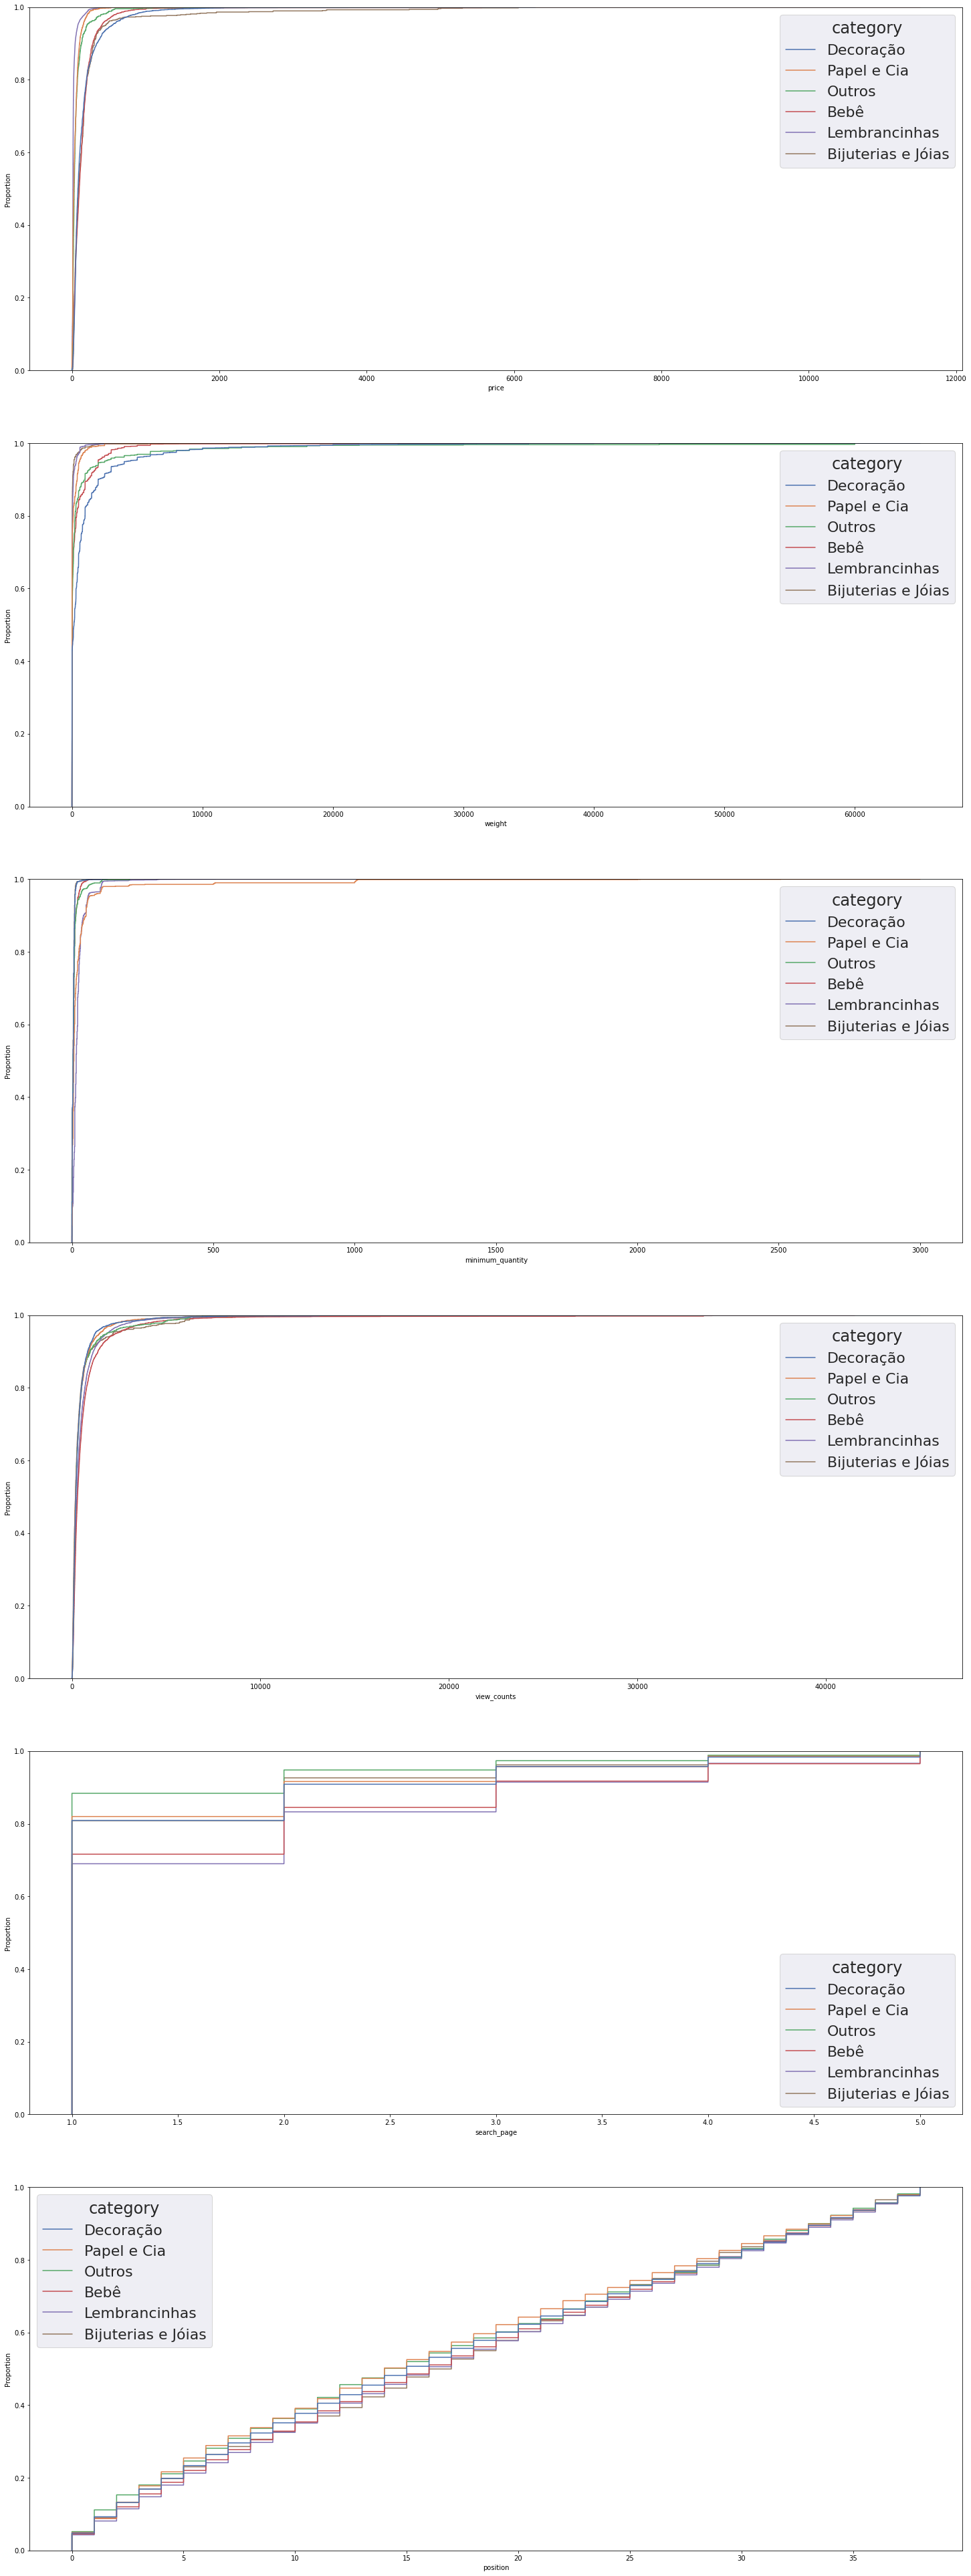

In [14]:
f, axes = plt.subplots(6, 1,figsize=(25,70))

sns.set(font_scale=2)

sns.ecdfplot(data=full_df,x="price",hue="category",ax=axes[0])
sns.ecdfplot(data=full_df,x="weight",hue="category",ax=axes[1])
sns.ecdfplot(data=full_df,x="minimum_quantity",hue="category",ax=axes[2])
sns.ecdfplot(data=full_df,x="view_counts",hue="category",ax=axes[3])
sns.ecdfplot(data=full_df,x="search_page",hue="category",ax=axes[4])
sns.ecdfplot(data=full_df,x="position",hue="category",ax=axes[5])


### BoxPlots of numerical variables with outliers

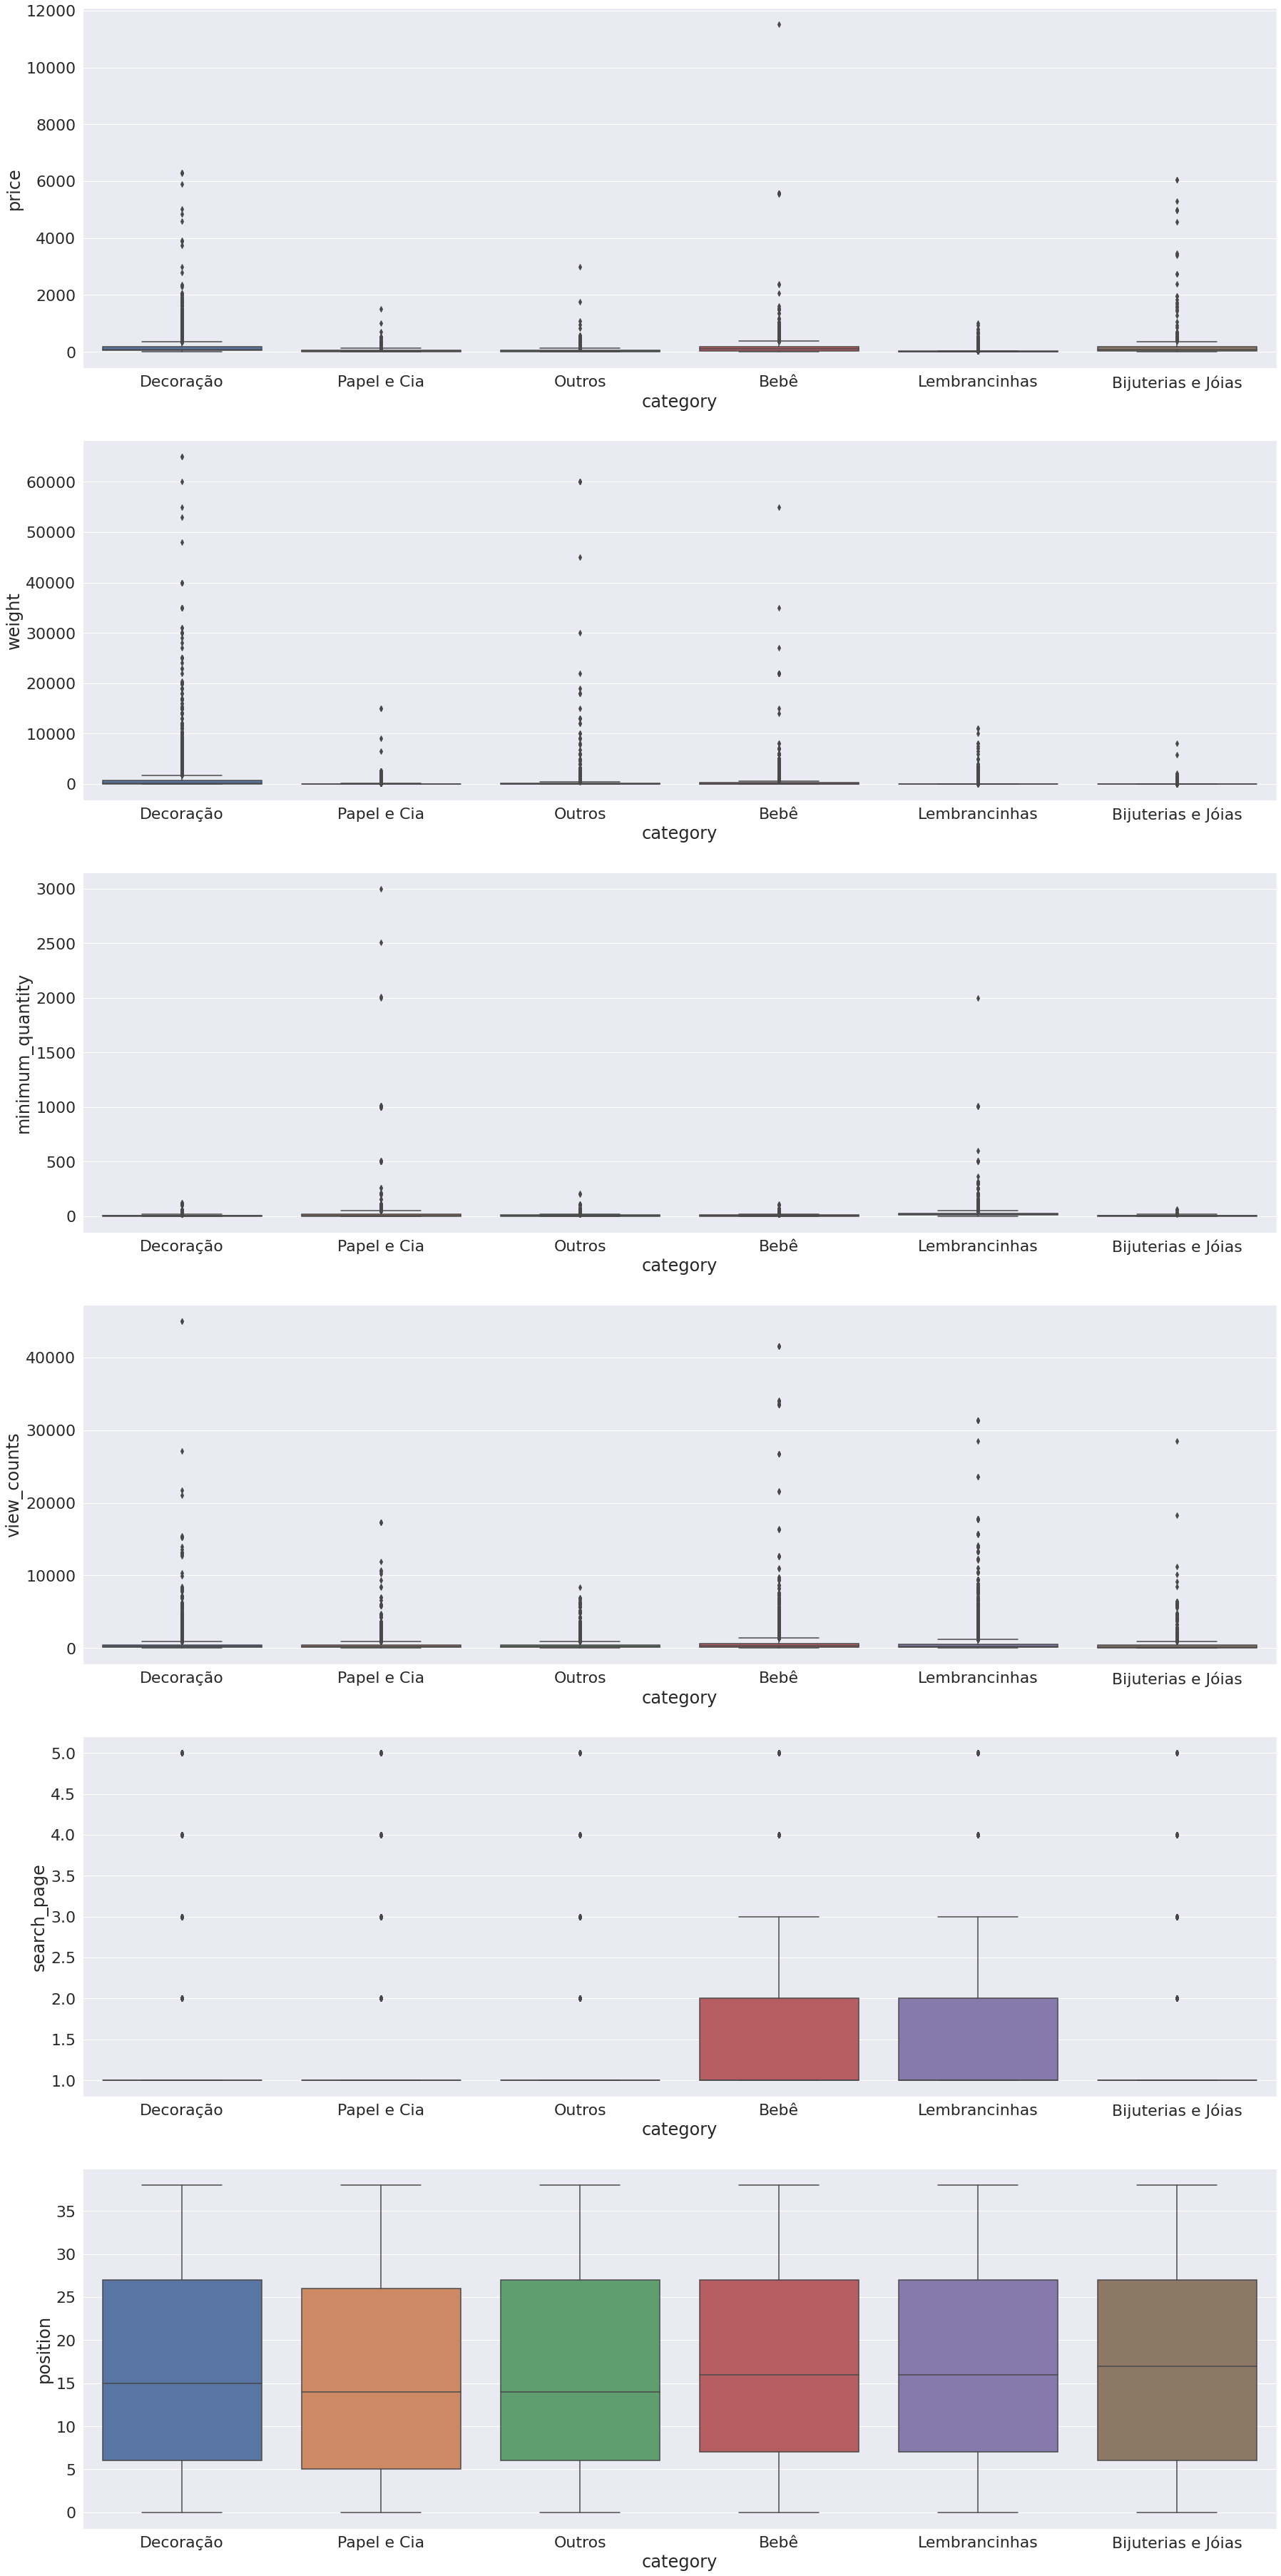

In [15]:
labels = ['Decoração', 'Papel e Cia', 'Outros', 'Bebê', 'Lembrancinhas','Bijuterias e Jóias']

f, axes = plt.subplots(6, 1,figsize=(30,65))

ax = sns.boxplot(x="category", y="price", data=full_df,ax=axes[0],order=labels)
ax = sns.boxplot(x="category", y="weight", data=full_df,ax=axes[1],order=labels)
ax = sns.boxplot(x="category", y="minimum_quantity", data=full_df,ax=axes[2],order=labels)
ax = sns.boxplot(x="category", y="view_counts", data=full_df,ax=axes[3],order=labels)
ax = sns.boxplot(x="category", y="search_page", data=full_df,ax=axes[4],order=labels)
ax = sns.boxplot(x="category", y="position", data=full_df,ax=axes[5],order=labels)

### BoxPlots of numerical variables without outliers

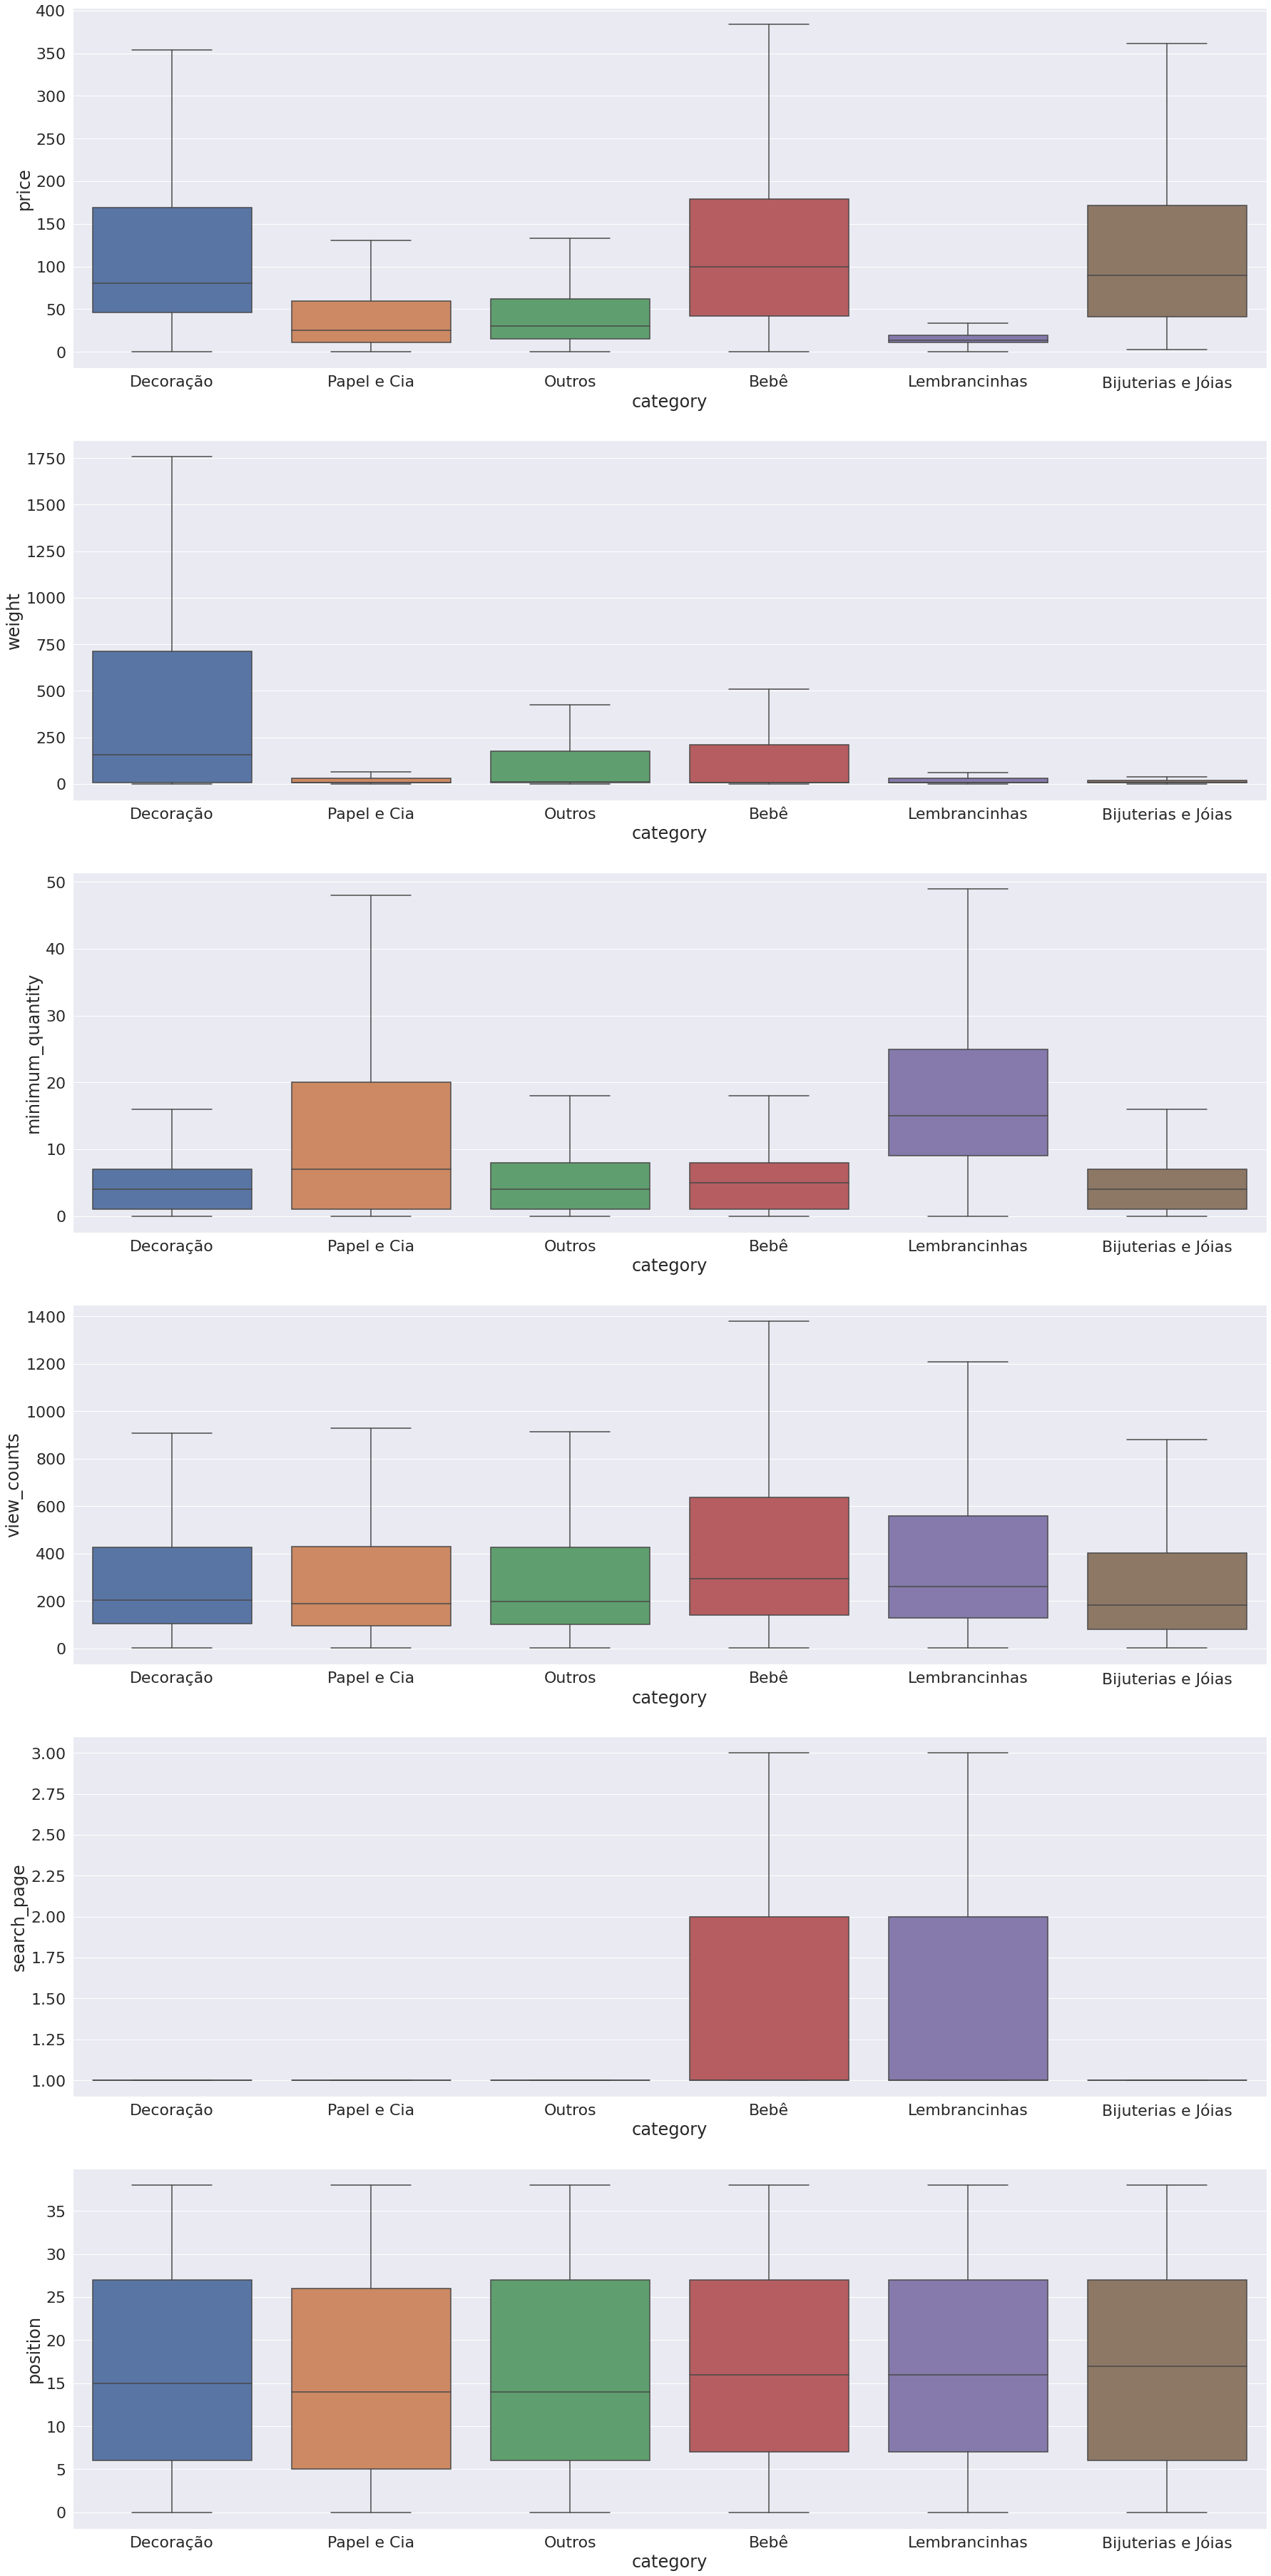

In [16]:
labels = ['Decoração', 'Papel e Cia', 'Outros', 'Bebê', 'Lembrancinhas','Bijuterias e Jóias']

f, axes = plt.subplots(6, 1,figsize=(30,65))

ax = sns.boxplot(x="category", y="price", data=full_df,ax=axes[0],order=labels, showfliers = False)
ax = sns.boxplot(x="category", y="weight", data=full_df,ax=axes[1],order=labels, showfliers = False)
ax = sns.boxplot(x="category", y="minimum_quantity", data=full_df,ax=axes[2],order=labels, showfliers = False)
ax = sns.boxplot(x="category", y="view_counts", data=full_df,ax=axes[3],order=labels,showfliers = False)
ax = sns.boxplot(x="category", y="search_page", data=full_df,ax=axes[4],order=labels,showfliers = False)
ax = sns.boxplot(x="category", y="position", data=full_df,ax=axes[5],order=labels,showfliers = False)

### Distribution of numerical variables by Histogram

/home/julio/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


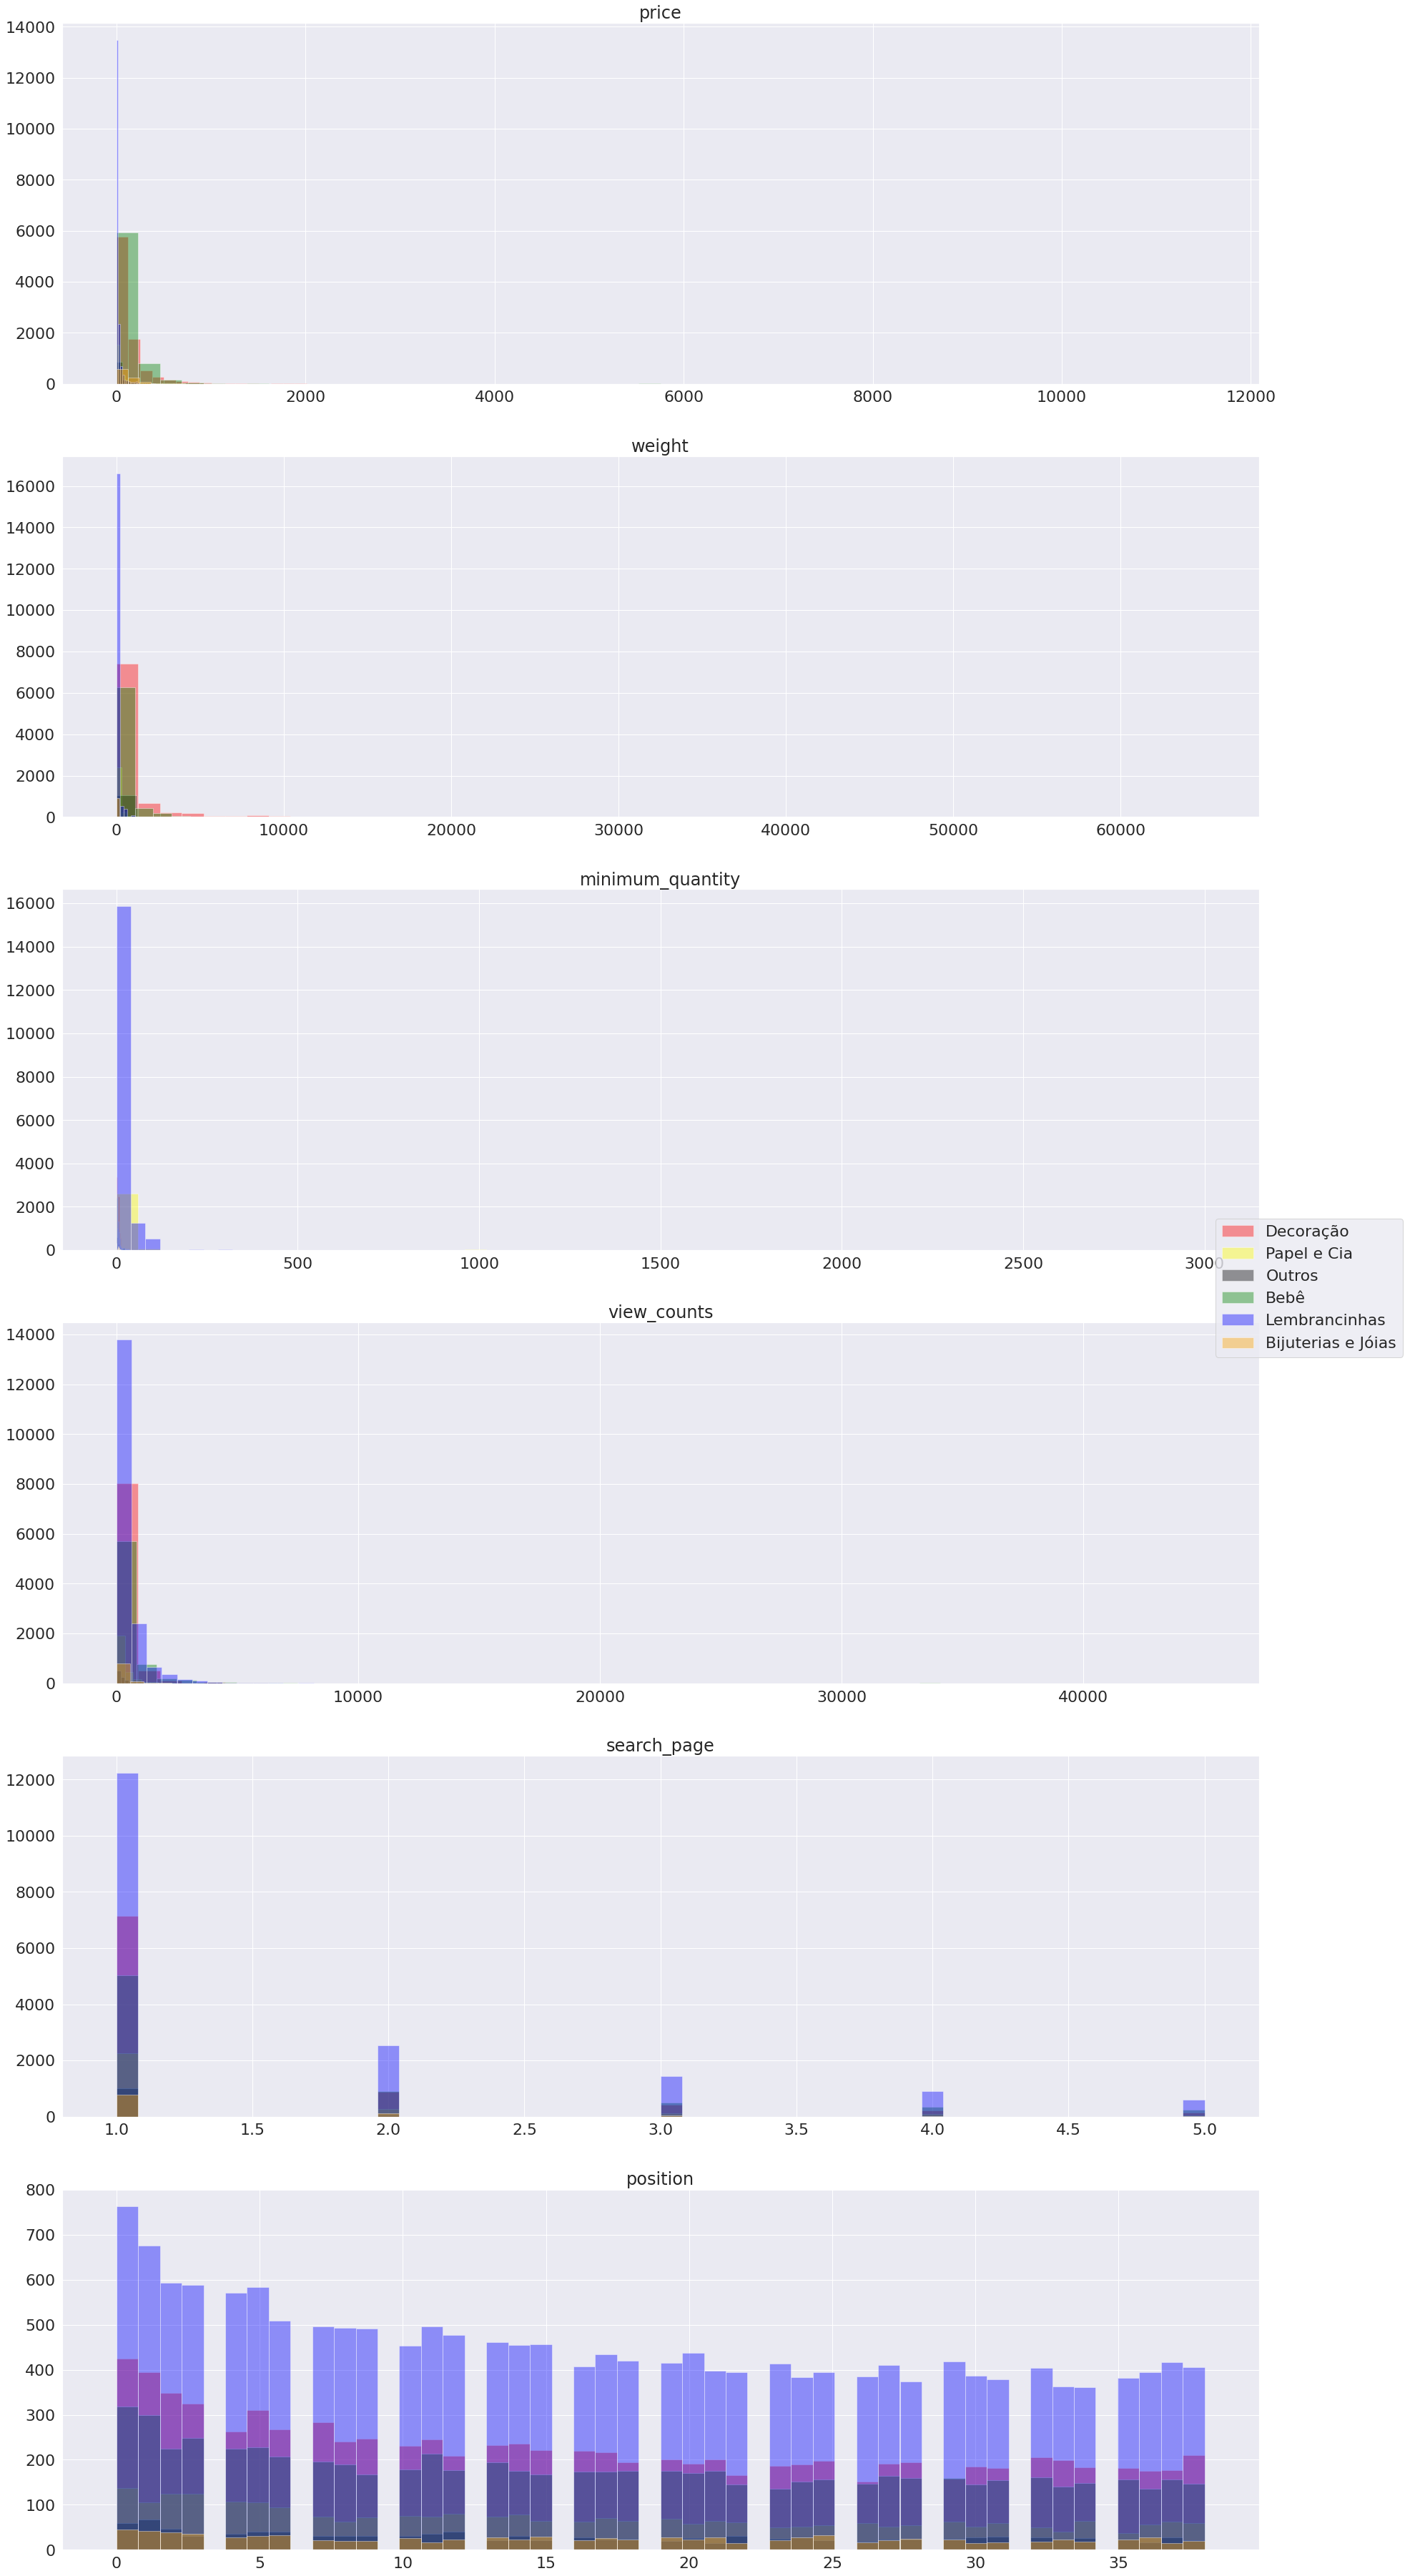

In [17]:
colors = ["red","yellow","black","green","blue","orange"]
n_bins = 50

f, axes = plt.subplots(6, 1,figsize=(30,65))

sns.distplot(full_df[full_df['category']=='Decoração']['price'].values, bins=n_bins, kde=False,label='Decoração',color=colors[0],ax=axes[0]).set_title("price")
sns.distplot(full_df[full_df['category']=='Papel e Cia']['price'].values, bins=n_bins, kde=False,label='Papel e Cia',color=colors[1],ax=axes[0]).set_title("price")
sns.distplot(full_df[full_df['category']=='Outros']['price'].values, bins=n_bins, kde=False,label='Outros',color=colors[2],ax=axes[0]).set_title("price")
sns.distplot(full_df[full_df['category']=='Bebê']['price'].values, bins=n_bins, kde=False,label='Bebê',color=colors[3],ax=axes[0]).set_title("price")
sns.distplot(full_df[full_df['category']=='Lembrancinhas']['price'].values, bins=n_bins, kde=False,label='Lembrancinhas',color=colors[4],ax=axes[0]).set_title("price")
sns.distplot(full_df[full_df['category']=='Bijuterias e Jóias']['price'].values, bins=n_bins, kde=False,label='Bijuterias e Jóias',color=colors[5],ax=axes[0]).set_title("price")

sns.distplot(full_df[full_df['category']=='Decoração']['weight'].values, bins=n_bins, kde=False,label='Decoração',color=colors[0],ax=axes[1]).set_title("weight")
sns.distplot(full_df[full_df['category']=='Papel e Cia']['weight'].values, bins=n_bins, kde=False,label='Papel e Cia',color=colors[1],ax=axes[1]).set_title("weight")
sns.distplot(full_df[full_df['category']=='Outros']['weight'].values, bins=n_bins, kde=False,label='Outros',color=colors[2],ax=axes[1]).set_title("weight")
sns.distplot(full_df[full_df['category']=='Bebê']['weight'].values, bins=n_bins, kde=False,label='Bebê',color=colors[3],ax=axes[1]).set_title("weight")
sns.distplot(full_df[full_df['category']=='Lembrancinhas']['weight'].values, bins=n_bins, kde=False,label='Lembrancinhas',color=colors[4],ax=axes[1]).set_title("weight")
sns.distplot(full_df[full_df['category']=='Bijuterias e Jóias']['weight'].values, bins=n_bins, kde=False,label='Bijuterias e Jóias',color=colors[5],ax=axes[1]).set_title("weight")


sns.distplot(full_df[full_df['category']=='Decoração']['minimum_quantity'].values, bins=n_bins, kde=False,label='Decoração',color=colors[0],ax=axes[2]).set_title("minimum_quantity")
sns.distplot(full_df[full_df['category']=='Papel e Cia']['minimum_quantity'].values, bins=n_bins, kde=False,label='Papel e Cia',color=colors[1],ax=axes[2]).set_title("minimum_quantity")
sns.distplot(full_df[full_df['category']=='Outros']['minimum_quantity'].values, bins=n_bins, kde=False,label='Outros',color=colors[2],ax=axes[2]).set_title("minimum_quantity")
sns.distplot(full_df[full_df['category']=='Bebê']['minimum_quantity'].values, bins=n_bins, kde=False,label='Bebê',color=colors[3],ax=axes[2]).set_title("minimum_quantity")
sns.distplot(full_df[full_df['category']=='Lembrancinhas']['minimum_quantity'].values, bins=n_bins, kde=False,label='Lembrancinhas',color=colors[4],ax=axes[2]).set_title("minimum_quantity")
sns.distplot(full_df[full_df['category']=='Bijuterias e Jóias']['minimum_quantity'].values, bins=n_bins, kde=False,label='Bijuterias e Jóias',color=colors[5],ax=axes[2]).set_title("minimum_quantity")



sns.distplot(full_df[full_df['category']=='Decoração']['view_counts'].values, bins=n_bins, kde=False,label='Decoração',color=colors[0],ax=axes[3]).set_title("view_counts")
sns.distplot(full_df[full_df['category']=='Papel e Cia']['view_counts'].values, bins=n_bins, kde=False,label='Papel e Cia',color=colors[1],ax=axes[3]).set_title("view_counts")
sns.distplot(full_df[full_df['category']=='Outros']['view_counts'].values, bins=n_bins, kde=False,label='Outros',color=colors[2],ax=axes[3]).set_title("view_counts")
sns.distplot(full_df[full_df['category']=='Bebê']['view_counts'].values, bins=n_bins, kde=False,label='Bebê',color=colors[3],ax=axes[3]).set_title("view_counts")
sns.distplot(full_df[full_df['category']=='Lembrancinhas']['view_counts'].values, bins=n_bins, kde=False,label='Lembrancinhas',color=colors[4],ax=axes[3]).set_title("view_counts")
sns.distplot(full_df[full_df['category']=='Bijuterias e Jóias']['view_counts'].values, bins=n_bins, kde=False,label='Bijuterias e Jóias',color=colors[5],ax=axes[3]).set_title("view_counts")




sns.distplot(full_df[full_df['category']=='Decoração']['search_page'].values, bins=n_bins, kde=False,label='Decoração',color=colors[0],ax=axes[4]).set_title("search_page")
sns.distplot(full_df[full_df['category']=='Papel e Cia']['search_page'].values, bins=n_bins, kde=False,label='Papel e Cia',color=colors[1],ax=axes[4]).set_title("search_page")
sns.distplot(full_df[full_df['category']=='Outros']['search_page'].values, bins=n_bins, kde=False,label='Outros',color=colors[2],ax=axes[4]).set_title("search_page")
sns.distplot(full_df[full_df['category']=='Bebê']['search_page'].values, bins=n_bins, kde=False,label='Bebê',color=colors[3],ax=axes[4]).set_title("search_page")
sns.distplot(full_df[full_df['category']=='Lembrancinhas']['search_page'].values, bins=n_bins, kde=False,label='Lembrancinhas',color=colors[4],ax=axes[4]).set_title("search_page")
sns.distplot(full_df[full_df['category']=='Bijuterias e Jóias']['search_page'].values, bins=n_bins, kde=False,label='Bijuterias e Jóias',color=colors[5],ax=axes[4]).set_title("search_page")



sns.distplot(full_df[full_df['category']=='Decoração']['position'].values, bins=n_bins, kde=False,label='Decoração',color=colors[0],ax=axes[5]).set_title("position")
sns.distplot(full_df[full_df['category']=='Papel e Cia']['position'].values, bins=n_bins, kde=False,label='Papel e Cia',color=colors[1],ax=axes[5]).set_title("position")
sns.distplot(full_df[full_df['category']=='Outros']['position'].values, bins=n_bins, kde=False,label='Outros',color=colors[2],ax=axes[5]).set_title("position")
sns.distplot(full_df[full_df['category']=='Bebê']['position'].values, bins=n_bins, kde=False,label='Bebê',color=colors[3],ax=axes[5]).set_title("position")
sns.distplot(full_df[full_df['category']=='Lembrancinhas']['position'].values, bins=n_bins, kde=False,label='Lembrancinhas',color=colors[4],ax=axes[5]).set_title("position")
sns.distplot(full_df[full_df['category']=='Bijuterias e Jóias']['position'].values, bins=n_bins, kde=False,label='Bijuterias e Jóias',color=colors[5],ax=axes[5]).set_title("position")



lines, labels = f.axes[-1].get_legend_handles_labels()
    
f.legend(lines, labels, loc = 'right')

plt.show()

### Analysis of categorical variables (query, title and concatenated_tags)

#### volume of unique values

In [18]:
print("unique values of variable query: {}".format(len(full_df["query"].unique())))
print("unique values of variable title: {}".format(len(full_df["title"].unique())))
print("unique values of variable concatenated_tags: {}".format(len(full_df["concatenated_tags"].unique())))

unique values of variable query: 6395
unique values of variable title: 25319
unique values of variable concatenated_tags: 22981


#### unique values

In [19]:
full_df["query"].unique()

array(['espirito santo', 'cartao de visita', 'expositor de esmaltes', ...,
       'kit 3 cortinas blecaute black out corta luz pvc cinza',
       'bolo paris', 'polaina tricot'], dtype=object)

In [20]:
full_df["title"].unique()

array(['Mandala Espírito Santo', 'Cartão de Visita',
       'Organizador expositor p/ 70 esmaltes', ...,
       'Copos Metalizados - Rosé', 'Kit Festa do Pijama Meninos',
       'Mini Baleiro Instrumentos Musicais'], dtype=object)

In [21]:
full_df["concatenated_tags"].unique()

array(['mandala mdf',
       'cartao visita panfletos tag adesivos copos long drink canecas',
       'expositor', ..., 'sapatinho kettlyn criancas kit enxoval bebe',
       'despedida bianca metalizados xvdakaw lembrancinhas copos tacas casamento',
       'tema musica instrumentos musicais festa musica'], dtype=object)

#### Clean text

In [22]:
full_df["query_cleaned"] = full_df["query"].apply(lambda x: text_cleaner(x))
full_df["concatenated_tags_cleaned"] = full_df["concatenated_tags"].apply(lambda x: text_cleaner(x))
full_df["title_cleaned"] = full_df["title"].apply(lambda x: text_cleaner(x))

/tmp/ipykernel_7422/1178620108.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  text['text'] = text['text'].str.replace(pat,'')


### Analysis of categorical variable query

#### Analysis with BOW (Bag of words) of variable query_cleaned

In [25]:
qnt_top_frequency_words  = 5



bow_query_decoracao = plot_bar_count_words(text_column="query_cleaned",
                                             label_column='category',
                                             name_class='Decoração',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_query_papel_e_cia = plot_bar_count_words(text_column="query_cleaned",
                                                 label_column='category',
                                                 name_class='Papel e Cia',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

bow_query_outros = plot_bar_count_words(text_column="query_cleaned",
                                             label_column='category',
                                             name_class='Outros',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_query_bebe = plot_bar_count_words(text_column="query_cleaned",
                                             label_column='category',
                                             name_class='Bebê',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_query_lembrancinhas = plot_bar_count_words(text_column="query_cleaned",
                                                 label_column='category',
                                                 name_class='Lembrancinhas',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

bow_query_biju_e_joias = plot_bar_count_words(text_column="query_cleaned",
                                                 label_column='category',
                                                 name_class='Bijuterias e Jóias',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

#### Identify words that appears with frequency in all classes in the variable query_cleaned

In [26]:
intersection_query = set.intersection(set(bow_query_decoracao["WORDS"].values),
                             set(bow_query_papel_e_cia["WORDS"].values),
                            set(bow_query_outros["WORDS"].values),
                            set(bow_query_bebe["WORDS"].values),
                            set(bow_query_lembrancinhas["WORDS"].values),
                            set(bow_query_biju_e_joias["WORDS"].values))

intersection_query = list(intersection_query)

print(intersection_query)

[]


#### Plot of the frequency of the words in the variable query_cleaned by each class

Text(0.5, 1.0, 'Bijuterias e Jóias')

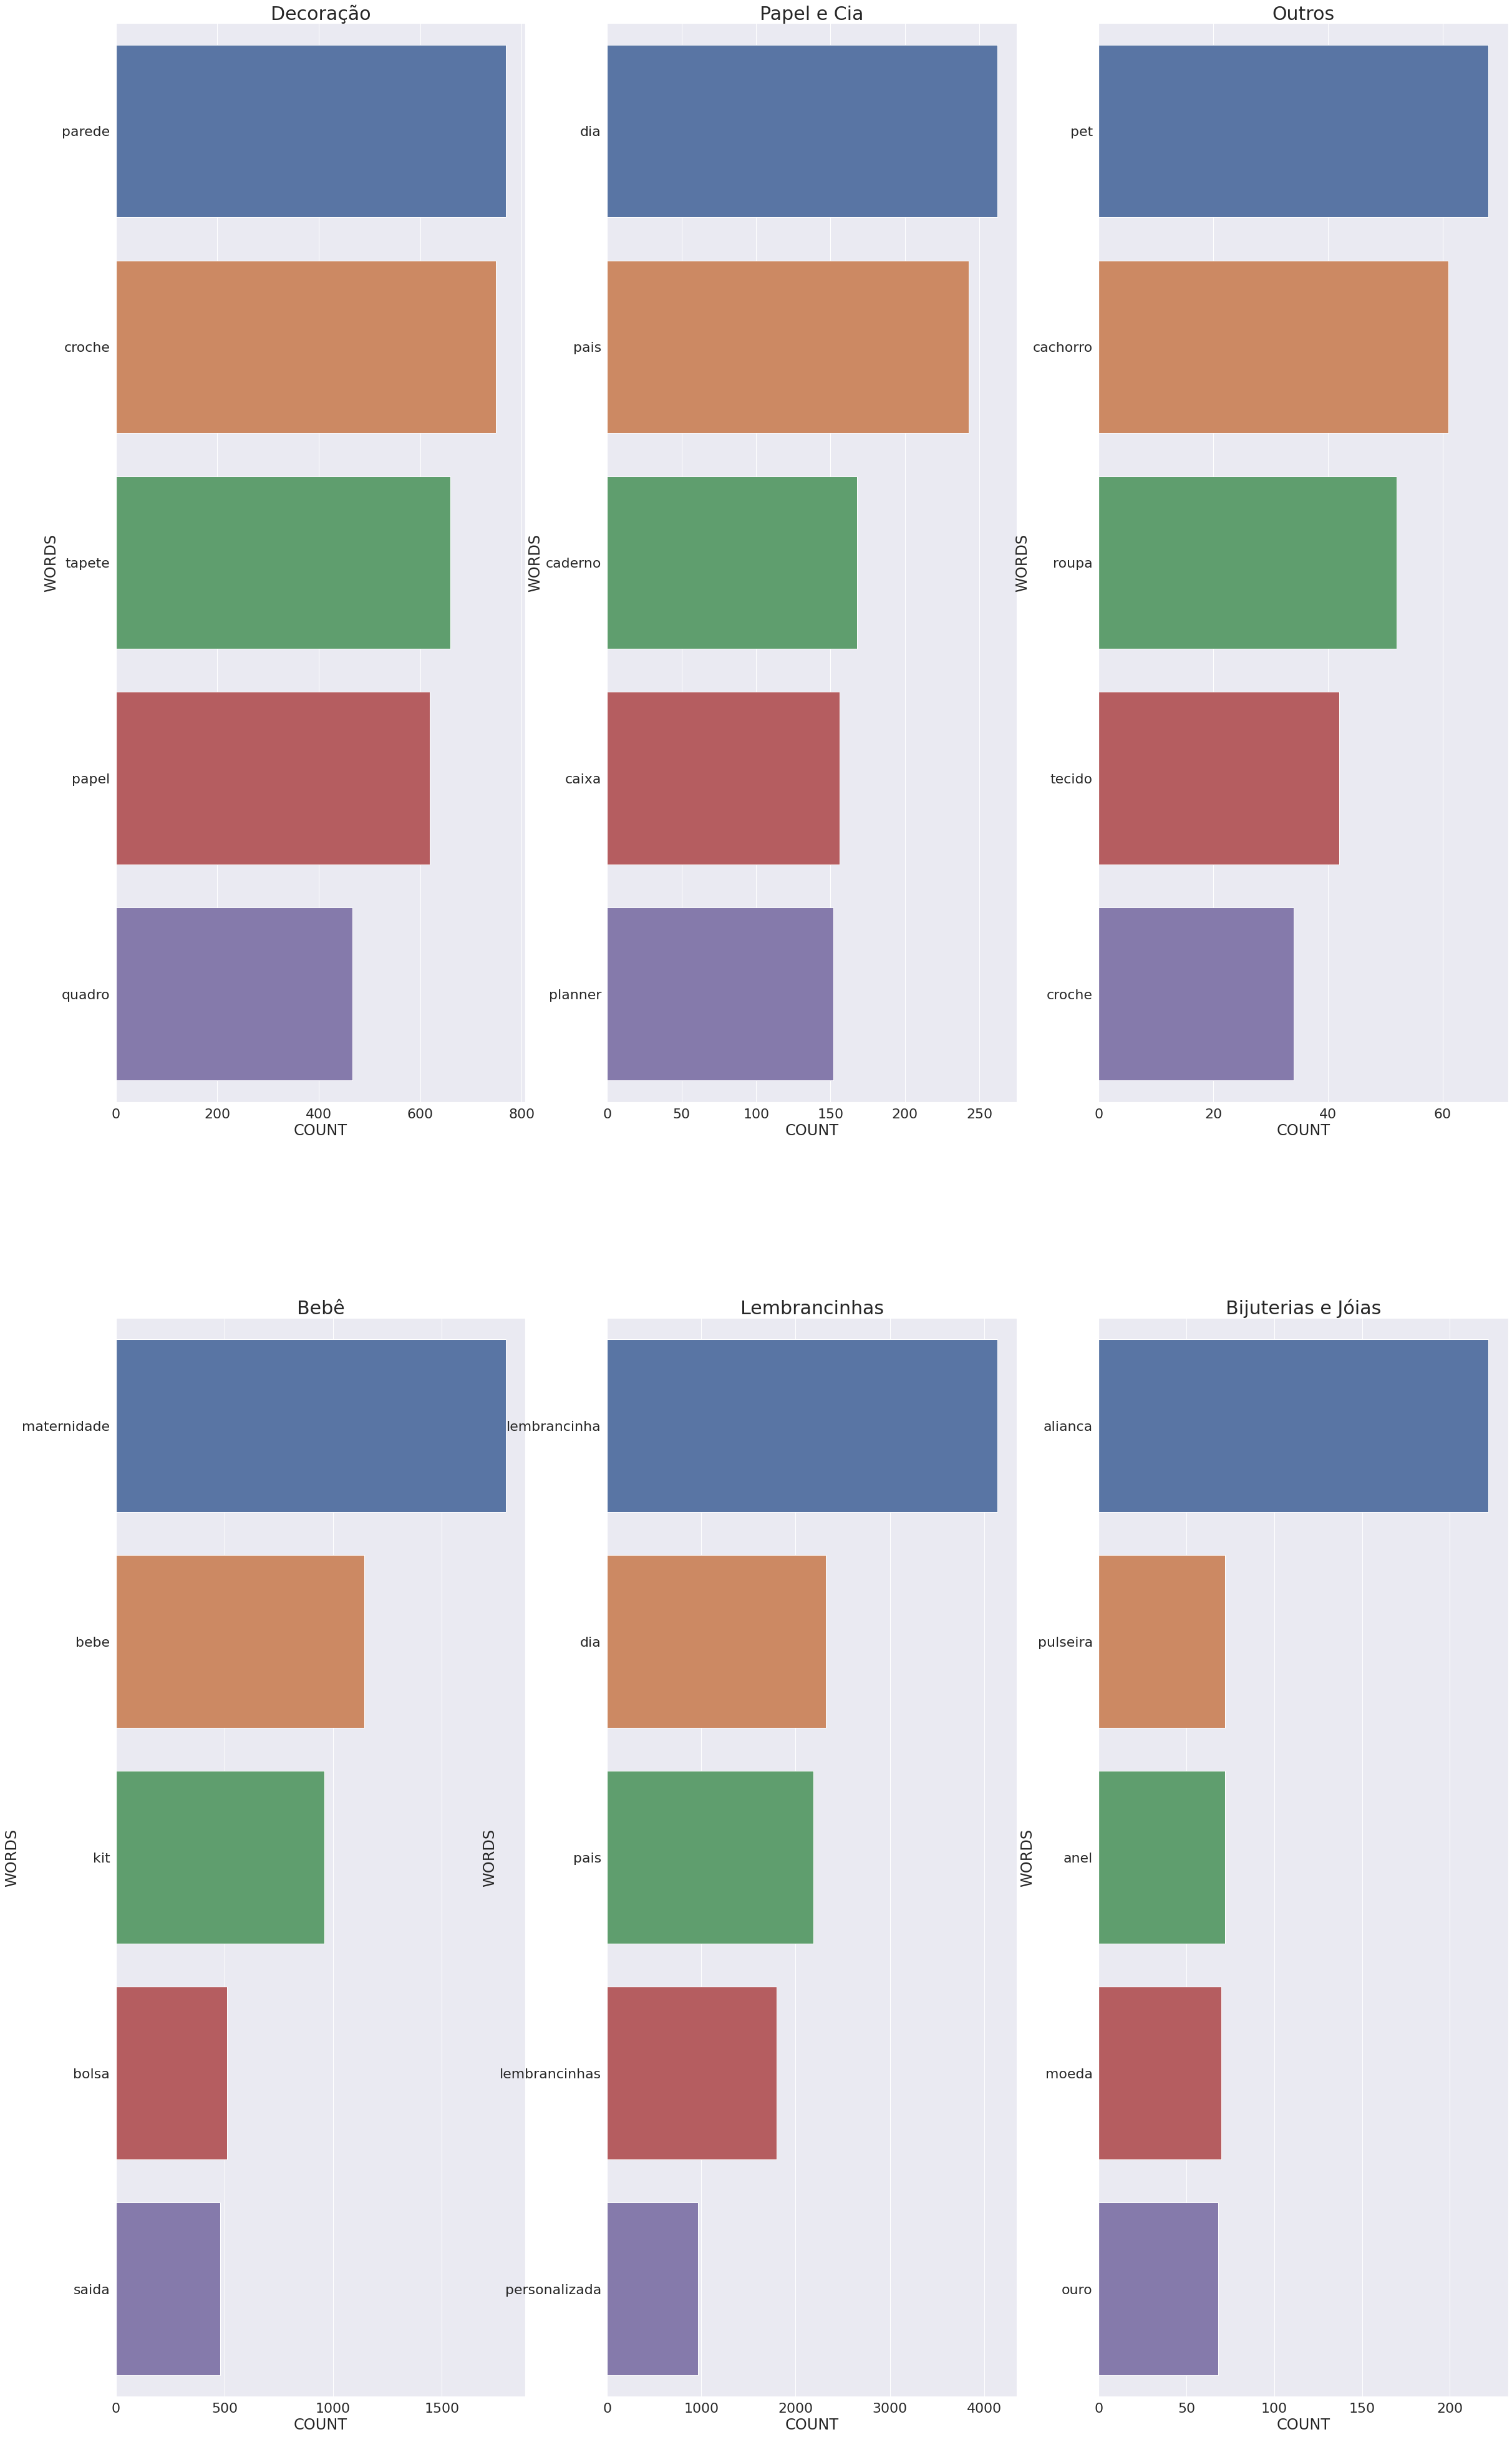

In [27]:
f, axes = plt.subplots(2, 3,figsize=(40,70))

sns.set(font_scale=2.5)

sns.barplot(x='COUNT', y="WORDS", data=bow_query_decoracao,ax=axes[0,0]).set_title("Decoração")
sns.barplot(x='COUNT', y="WORDS", data=bow_query_papel_e_cia,ax=axes[0,1]).set_title("Papel e Cia")
sns.barplot(x='COUNT', y="WORDS", data=bow_query_outros,ax=axes[0,2]).set_title("Outros")

sns.barplot(x='COUNT', y="WORDS", data=bow_query_bebe,ax=axes[1,0]).set_title("Bebê")
sns.barplot(x='COUNT', y="WORDS", data=bow_query_lembrancinhas,ax=axes[1,1]).set_title("Lembrancinhas")
sns.barplot(x='COUNT', y="WORDS", data=bow_query_biju_e_joias,ax=axes[1,2]).set_title("Bijuterias e Jóias")

#### Count of the number of classes that top frequency words of the variable query_cleaned appears

In [28]:
bow_query_decoracao["Category"] =  'Decoração'
bow_query_papel_e_cia["Category"] = 'Papel e Cia'
bow_query_outros["Category"] = 'Outros'
bow_query_bebe["Category"] = 'Bebê'
bow_query_lembrancinhas["Category"] = 'Lembrancinhas'
bow_query_biju_e_joias["Category"] = 'Bijuterias e Jóias'

bow_query_all_classes = pd.concat([bow_query_decoracao,
                                  bow_query_papel_e_cia,
                                  bow_query_outros,
                                  bow_query_bebe,
                                  bow_query_lembrancinhas,
                                  bow_query_biju_e_joias],axis=0)

bow_query_all_classes = bow_query_all_classes.groupby("WORDS").count().sort_values(ascending=False,by=["COUNT"])
bow_query_all_classes = bow_query_all_classes[["COUNT"]]

bow_query_all_classes[bow_query_all_classes["COUNT"]>1]

,COUNT
WORDS,
pais,2
croche,2
dia,2


#### Final words for pre-processing of the query_cleaned

In [29]:
words_processing_query = list(bow_query_all_classes[bow_query_all_classes["COUNT"]==1].index)
words_processing_query

['alianca',
 'tapete',
 'saida',
 'roupa',
 'quadro',
 'pulseira',
 'planner',
 'pet',
 'personalizada',
 'parede',
 'papel',
 'moeda',
 'ouro',
 'anel',
 'maternidade',
 'lembrancinhas',
 'lembrancinha',
 'kit',
 'caixa',
 'caderno',
 'cachorro',
 'bolsa',
 'bebe',
 'tecido']

### Analysis of categorical variable title

#### Analysis with BOW (Bag of words) of variable title_cleaned

In [30]:
qnt_top_frequency_words  = 5



bow_title_decoracao = plot_bar_count_words(text_column="title_cleaned",
                                             label_column='category',
                                             name_class='Decoração',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_title_papel_e_cia = plot_bar_count_words(text_column="title_cleaned",
                                                 label_column='category',
                                                 name_class='Papel e Cia',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

bow_title_outros = plot_bar_count_words(text_column="title_cleaned",
                                             label_column='category',
                                             name_class='Outros',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_title_bebe = plot_bar_count_words(text_column="title_cleaned",
                                             label_column='category',
                                             name_class='Bebê',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_title_lembrancinhas = plot_bar_count_words(text_column="title_cleaned",
                                                 label_column='category',
                                                 name_class='Lembrancinhas',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

bow_title_biju_e_joias = plot_bar_count_words(text_column="title_cleaned",
                                                 label_column='category',
                                                 name_class='Bijuterias e Jóias',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

#### Identify words that appears with frequency in all classes in the variable title_cleaned

In [31]:
intersection_title = set.intersection(set(bow_title_decoracao["WORDS"].values),
                             set(bow_title_papel_e_cia["WORDS"].values),
                            set(bow_title_outros["WORDS"].values),
                            set(bow_title_bebe["WORDS"].values),
                            set(bow_title_lembrancinhas["WORDS"].values),
                            set(bow_title_biju_e_joias["WORDS"].values))

intersection_title = list(intersection_title)

print(intersection_title)

[]


#### Plot of the frequency of the words in the variable title_cleaned by each class

Text(0.5, 1.0, 'Bijuterias e Jóias')

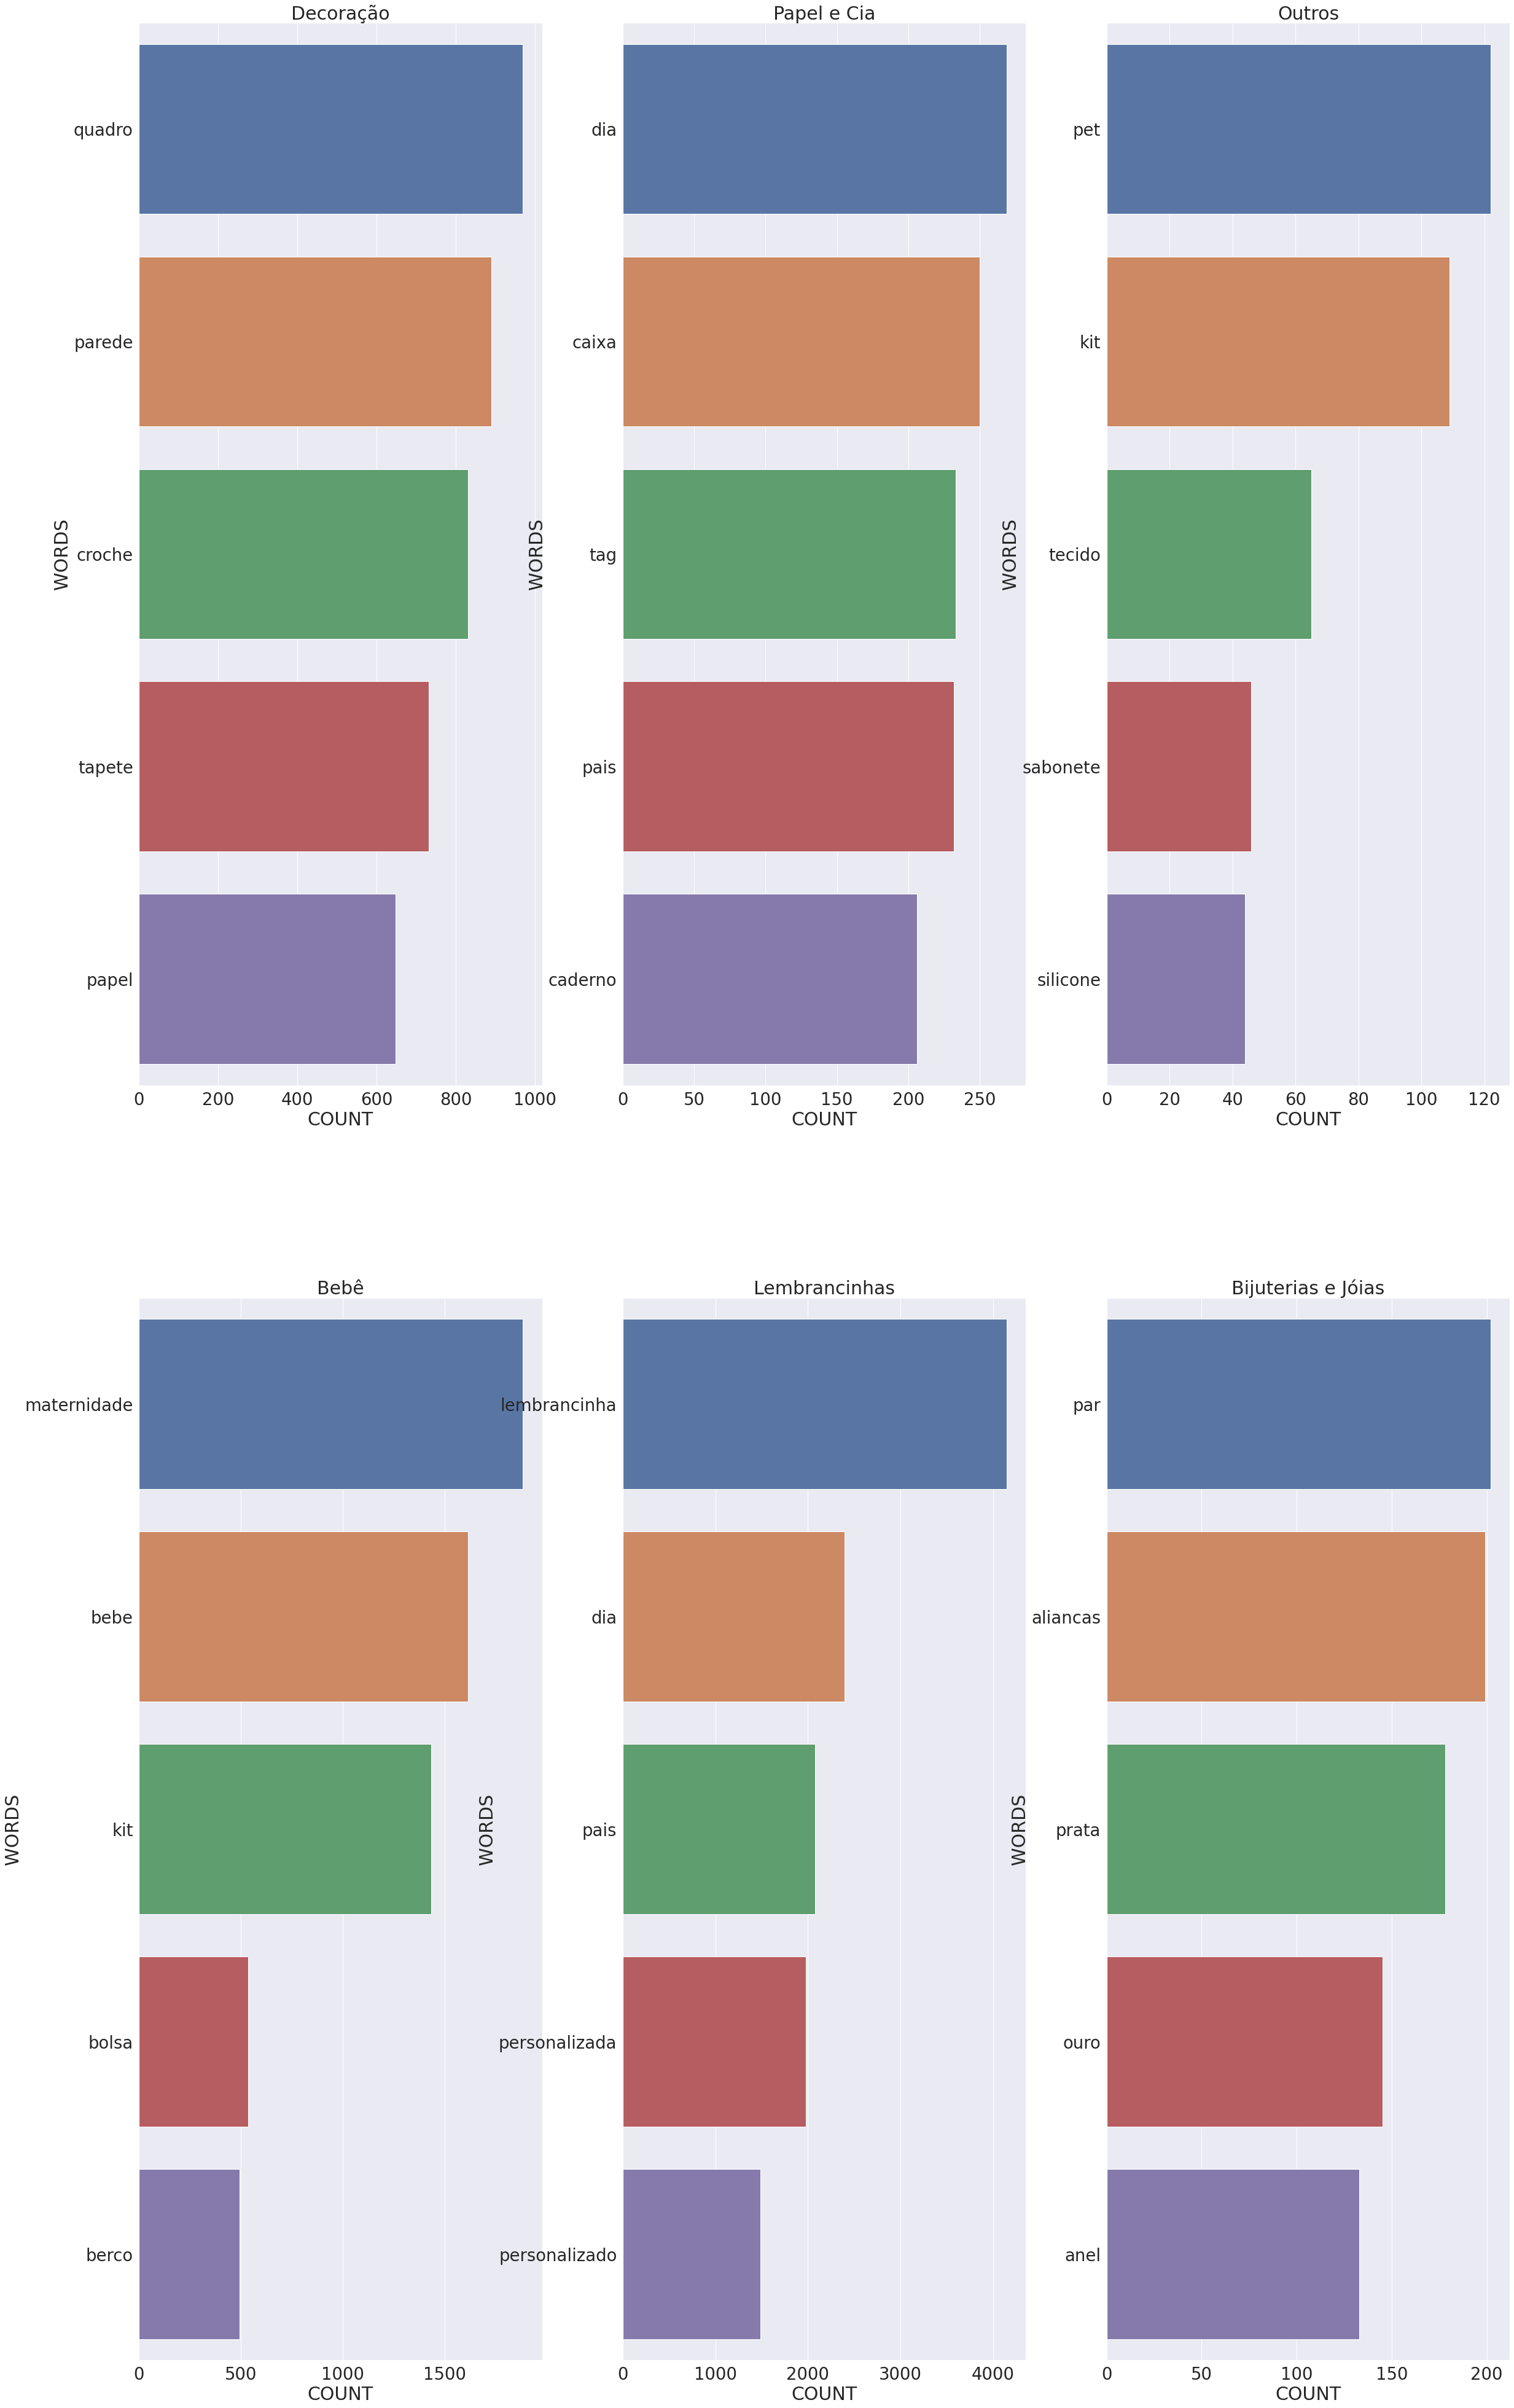

In [32]:
f, axes = plt.subplots(2, 3,figsize=(40,70))

sns.set(font_scale=2.5)

sns.barplot(x='COUNT', y="WORDS", data=bow_title_decoracao,ax=axes[0,0]).set_title("Decoração")
sns.barplot(x='COUNT', y="WORDS", data=bow_title_papel_e_cia,ax=axes[0,1]).set_title("Papel e Cia")
sns.barplot(x='COUNT', y="WORDS", data=bow_title_outros,ax=axes[0,2]).set_title("Outros")

sns.barplot(x='COUNT', y="WORDS", data=bow_title_bebe,ax=axes[1,0]).set_title("Bebê")
sns.barplot(x='COUNT', y="WORDS", data=bow_title_lembrancinhas,ax=axes[1,1]).set_title("Lembrancinhas")
sns.barplot(x='COUNT', y="WORDS", data=bow_title_biju_e_joias,ax=axes[1,2]).set_title("Bijuterias e Jóias")

#### Count of the number of classes that top frequency words of the variable title_cleaned appears

In [33]:
bow_title_decoracao["Category"] =  'Decoração'
bow_title_papel_e_cia["Category"] = 'Papel e Cia'
bow_title_outros["Category"] = 'Outros'
bow_title_bebe["Category"] = 'Bebê'
bow_title_lembrancinhas["Category"] = 'Lembrancinhas'
bow_title_biju_e_joias["Category"] = 'Bijuterias e Jóias'

bow_title_all_classes = pd.concat([bow_title_decoracao,
                                  bow_title_papel_e_cia,
                                  bow_title_outros,
                                  bow_title_bebe,
                                  bow_title_lembrancinhas,
                                  bow_title_biju_e_joias],axis=0)

bow_title_all_classes = bow_title_all_classes.groupby("WORDS").count().sort_values(ascending=False,by=["COUNT"])
bow_title_all_classes = bow_title_all_classes[["COUNT"]]

bow_title_all_classes[bow_title_all_classes["COUNT"]>1]

,COUNT
WORDS,
pais,2
dia,2
kit,2


#### Final words for pre-processing of the title_cleaned

In [34]:
words_processing_title = list(bow_title_all_classes[bow_title_all_classes["COUNT"]==1].index)
words_processing_title

['par',
 'tapete',
 'tag',
 'silicone',
 'sabonete',
 'quadro',
 'prata',
 'pet',
 'personalizado',
 'personalizada',
 'parede',
 'aliancas',
 'papel',
 'anel',
 'ouro',
 'maternidade',
 'lembrancinha',
 'croche',
 'caixa',
 'caderno',
 'bolsa',
 'berco',
 'bebe',
 'tecido']

### Analysis of categorical variable concatenated_tags

#### Analysis with BOW (Bag of words) of variable concatenated_tags_cleaned 

In [35]:
qnt_top_frequency_words  = 5



bow_concatenated_tags_decoracao = plot_bar_count_words(text_column="concatenated_tags_cleaned",
                                             label_column='category',
                                             name_class='Decoração',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_concatenated_tags_papel_e_cia = plot_bar_count_words(text_column="concatenated_tags_cleaned",
                                                 label_column='category',
                                                 name_class='Papel e Cia',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

bow_concatenated_tags_outros = plot_bar_count_words(text_column="concatenated_tags_cleaned",
                                             label_column='category',
                                             name_class='Outros',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_concatenated_tags_bebe = plot_bar_count_words(text_column="concatenated_tags_cleaned",
                                             label_column='category',
                                             name_class='Bebê',
                                             dataframe=full_df,
                                             metric='COUNT',
                                             top=qnt_top_frequency_words,return_df=True)

bow_concatenated_tags_lembrancinhas = plot_bar_count_words(text_column="concatenated_tags_cleaned",
                                                 label_column='category',
                                                 name_class='Lembrancinhas',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

bow_concatenated_tags_biju_e_joias = plot_bar_count_words(text_column="concatenated_tags_cleaned",
                                                 label_column='category',
                                                 name_class='Bijuterias e Jóias',
                                                 dataframe=full_df,
                                                 metric='COUNT',
                                                 top=qnt_top_frequency_words,return_df=True)

#### Identify words that appears with frequency in all classes in the variable concatenated_tags_cleaned

In [36]:
intersection_concatenated_tags = set.intersection(set(bow_concatenated_tags_decoracao["WORDS"].values),
                             set(bow_concatenated_tags_papel_e_cia["WORDS"].values),
                            set(bow_concatenated_tags_outros["WORDS"].values),
                            set(bow_concatenated_tags_bebe["WORDS"].values),
                            set(bow_concatenated_tags_lembrancinhas["WORDS"].values),
                            set(bow_concatenated_tags_biju_e_joias["WORDS"].values))

intersection_concatenated_tags = list(intersection_concatenated_tags)

print(intersection_concatenated_tags)

[]


#### Plot of the frequency of the words in the variable concatenated_tags_cleaned by each class

Text(0.5, 1.0, 'Bijuterias e Jóias')

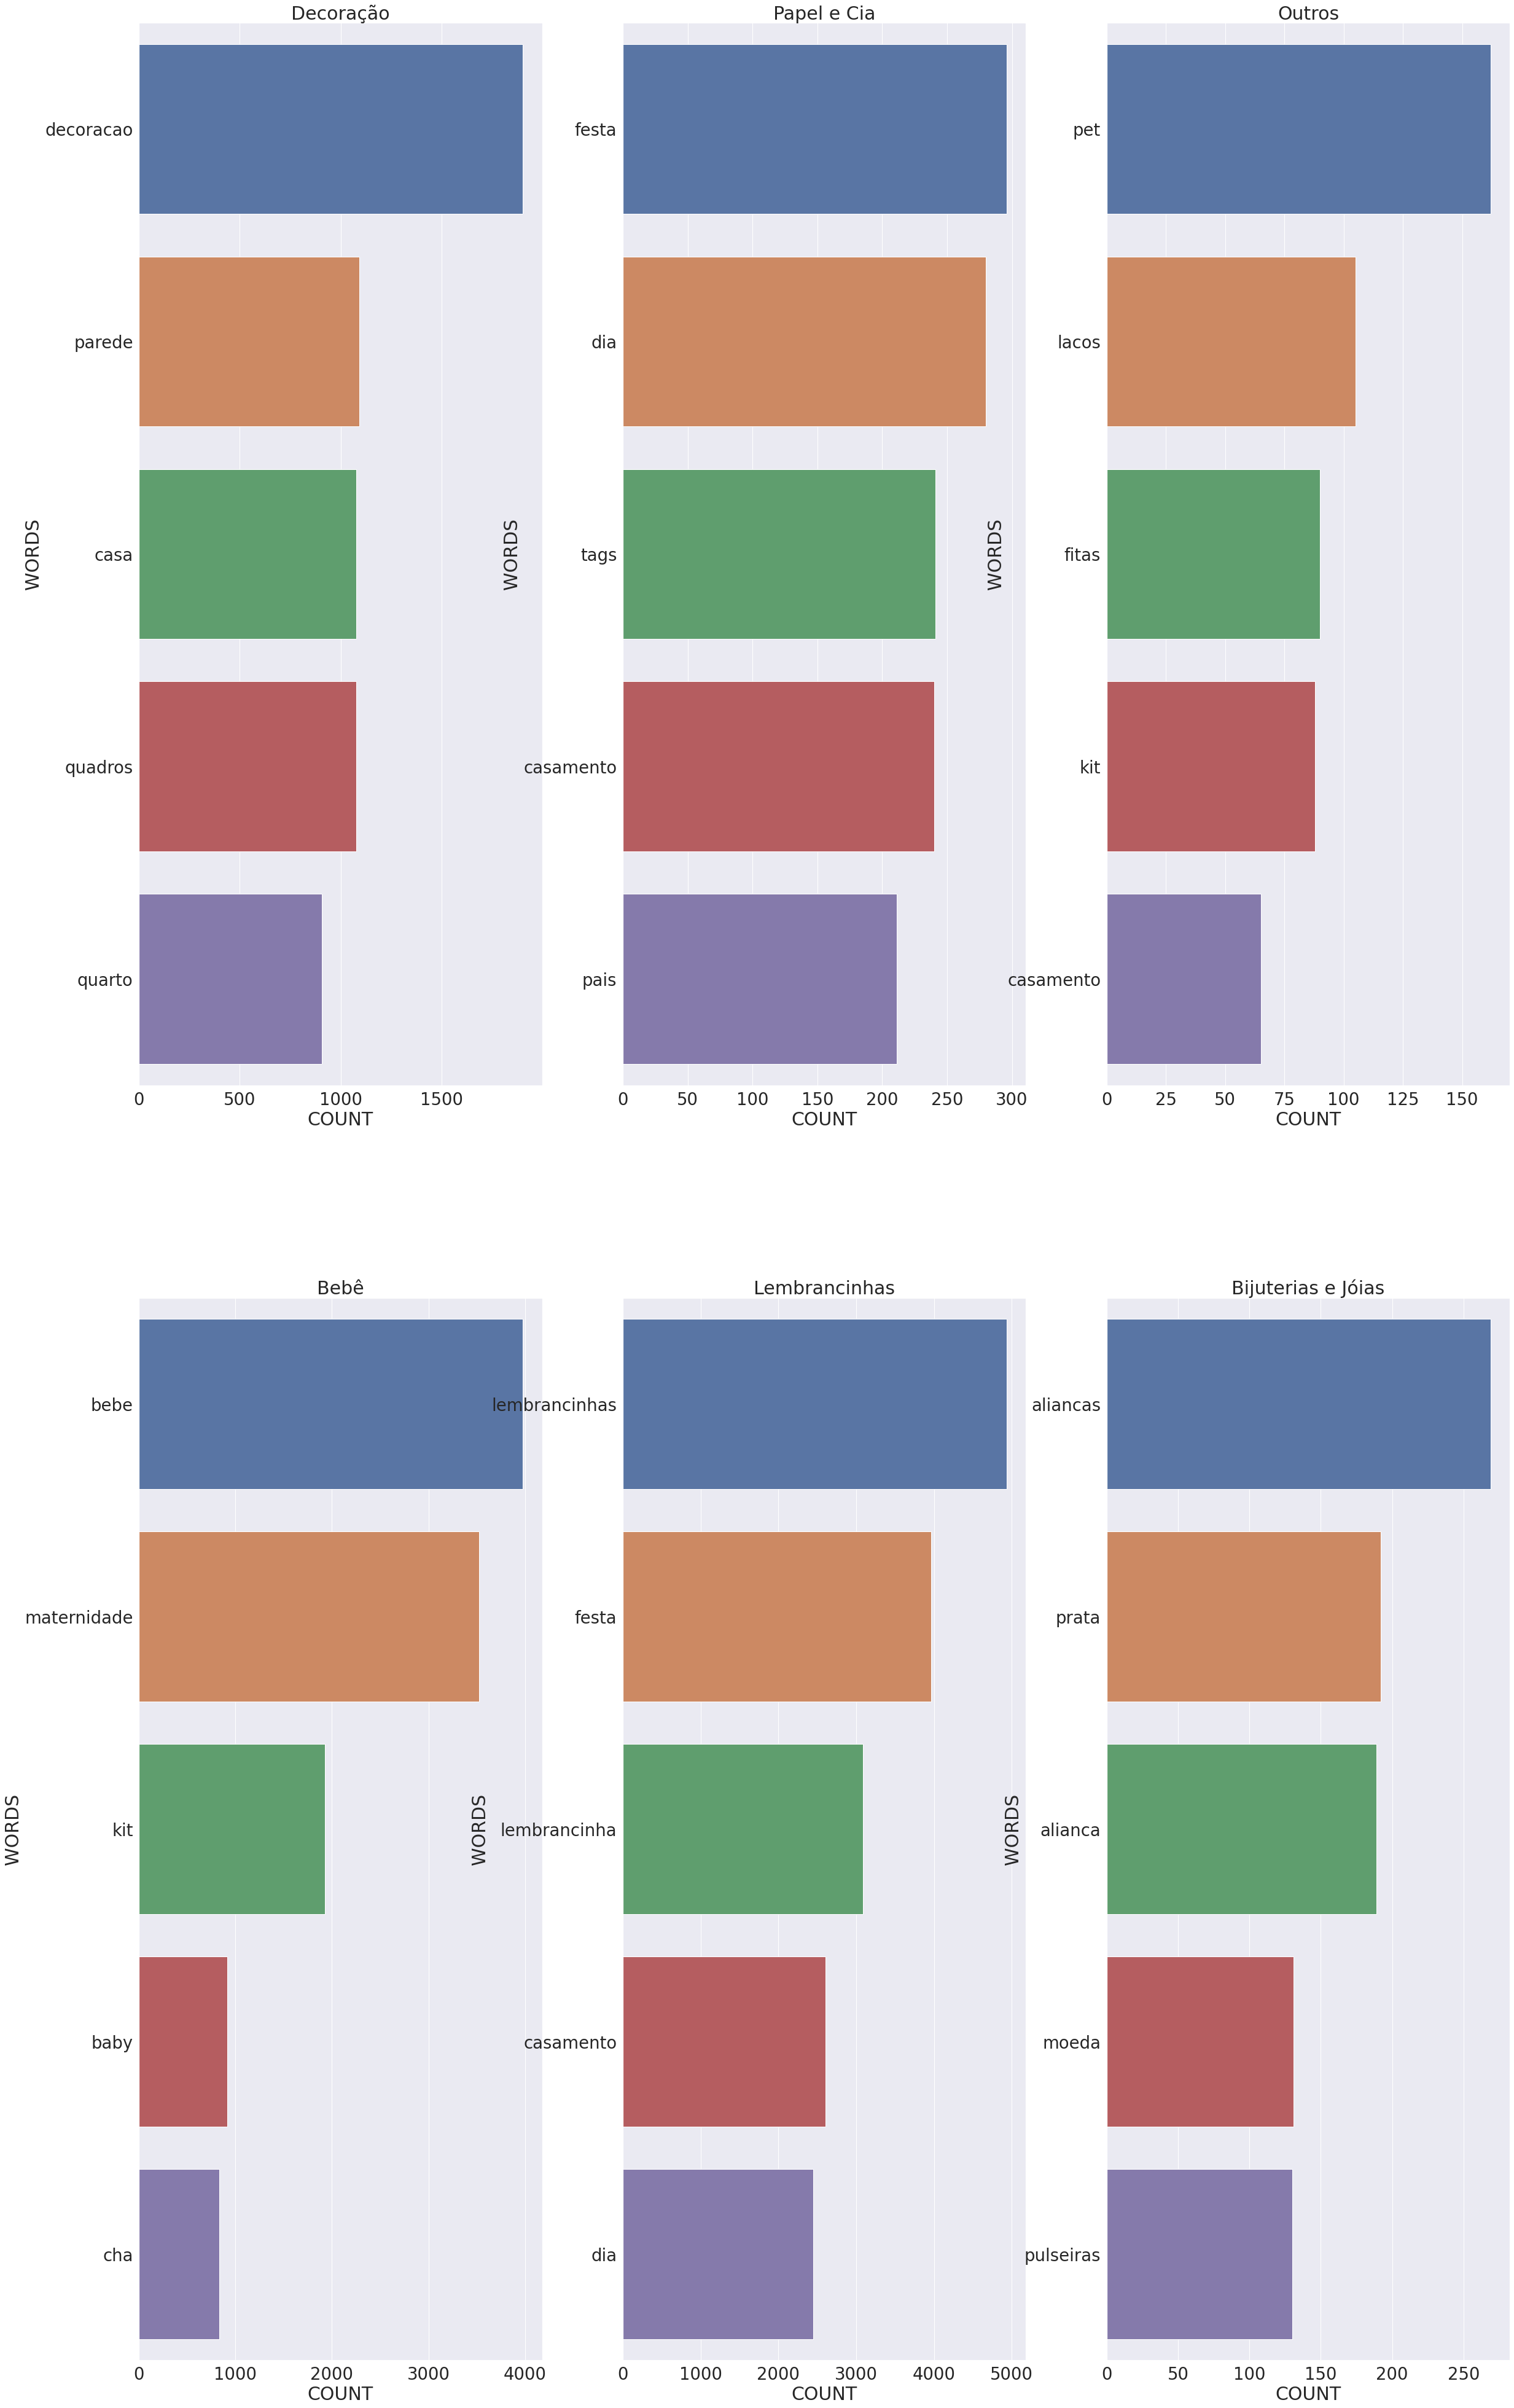

In [37]:
f, axes = plt.subplots(2, 3,figsize=(40,70))

sns.set(font_scale=2.5)

sns.barplot(x='COUNT', y="WORDS", data=bow_concatenated_tags_decoracao,ax=axes[0,0]).set_title("Decoração")
sns.barplot(x='COUNT', y="WORDS", data=bow_concatenated_tags_papel_e_cia,ax=axes[0,1]).set_title("Papel e Cia")
sns.barplot(x='COUNT', y="WORDS", data=bow_concatenated_tags_outros,ax=axes[0,2]).set_title("Outros")

sns.barplot(x='COUNT', y="WORDS", data=bow_concatenated_tags_bebe,ax=axes[1,0]).set_title("Bebê")
sns.barplot(x='COUNT', y="WORDS", data=bow_concatenated_tags_lembrancinhas,ax=axes[1,1]).set_title("Lembrancinhas")
sns.barplot(x='COUNT', y="WORDS", data=bow_concatenated_tags_biju_e_joias,ax=axes[1,2]).set_title("Bijuterias e Jóias")

#### Count of the number of classes that top frequency words of the variable concatenated_tags_cleaned appears

In [38]:
bow_concatenated_tags_decoracao["Category"] =  'Decoração'
bow_concatenated_tags_papel_e_cia["Category"] = 'Papel e Cia'
bow_concatenated_tags_outros["Category"] = 'Outros'
bow_concatenated_tags_bebe["Category"] = 'Bebê'
bow_concatenated_tags_lembrancinhas["Category"] = 'Lembrancinhas'
bow_concatenated_tags_biju_e_joias["Category"] = 'Bijuterias e Jóias'

bow_concatenated_tags_all_classes = pd.concat([bow_concatenated_tags_decoracao,
                                  bow_concatenated_tags_papel_e_cia,
                                  bow_concatenated_tags_outros,
                                  bow_concatenated_tags_bebe,
                                  bow_concatenated_tags_lembrancinhas,
                                  bow_concatenated_tags_biju_e_joias],axis=0)

bow_concatenated_tags_all_classes = bow_concatenated_tags_all_classes.groupby("WORDS").count().sort_values(ascending=False,by=["COUNT"])
bow_concatenated_tags_all_classes = bow_concatenated_tags_all_classes[["COUNT"]]

bow_concatenated_tags_all_classes[bow_concatenated_tags_all_classes["COUNT"]>1]

,COUNT
WORDS,
casamento,3
dia,2
festa,2
kit,2


#### Final words for pre-processing of the concatenated_tags_cleaned

In [39]:
words_processing_concatenated_tags = list(bow_concatenated_tags_all_classes[bow_concatenated_tags_all_classes["COUNT"]==1].index)
words_processing_concatenated_tags

['alianca',
 'maternidade',
 'quarto',
 'quadros',
 'pulseiras',
 'prata',
 'pet',
 'parede',
 'pais',
 'moeda',
 'lacos',
 'lembrancinhas',
 'lembrancinha',
 'aliancas',
 'fitas',
 'decoracao',
 'cha',
 'casa',
 'bebe',
 'baby',
 'tags']

# Pre-processing of the model

### pre-processing categorical variables

In [40]:
full_df["query_cleaned_modified"] = full_df["query_cleaned"].apply(lambda x: text_categorizer(text=x,labels=words_processing_query))
full_df["concatenated_tags_cleaned_modified"] = full_df["concatenated_tags_cleaned"].apply(lambda x: text_categorizer(text=x,labels=words_processing_concatenated_tags))
full_df["title_cleaned_modified"] = full_df["title_cleaned"].apply(lambda x: text_categorizer(text=x,labels=words_processing_title))

### Create Dummy variables with  query_cleaned_modified, concatenated_tags_cleaned_modified, title_cleaned_modified

In [43]:
df_dummies_query = pd.get_dummies(full_df['query_cleaned_modified'], drop_first=True, prefix='query')
df_dummies_concatenated = pd.get_dummies(full_df['concatenated_tags_cleaned_modified'], drop_first=True, prefix='concatenated_tags')
df_dummies_title = pd.get_dummies(full_df['title_cleaned_modified'], drop_first=True, prefix='title')

full_dummies = pd.concat([df_dummies_query,df_dummies_concatenated,df_dummies_title],axis=1)


In [44]:
full_df.drop(['query_cleaned_modified',
              'concatenated_tags_cleaned_modified',
              'title_cleaned_modified',
              'query_cleaned',
              'concatenated_tags_cleaned',
              'title_cleaned',"title","concatenated_tags","query"],inplace=True,axis=1)

full_df = pd.concat([full_df,full_dummies],axis=1)

full_df.head()

,product_id,seller_id,search_page,position,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,...,title_maternidade,title_papel,title_par,title_personalizado,title_pet,title_quadro,title_sabonete,title_tag,title_tapete,title_tecido
0,11394449,8324141,2,6,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,...,0,0,0,0,0,0,0,0,0,0
1,15534262,6939286,2,0,2018-04-04 20:55:07,77.670000,8.0,1,5,124,...,0,0,0,0,0,0,0,0,0,0
2,16153119,9835835,1,38,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,...,0,0,0,0,0,0,0,0,0,0
3,15877252,8071206,1,6,2017-02-27 13:26:03,118.770004,0.0,1,1,180,...,0,0,0,0,0,0,0,0,0,0
4,15917108,7200773,3,38,2017-05-09 13:18:38,191.810000,507.0,1,6,34,...,0,0,0,0,0,0,0,0,0,0


# Benchmark of the models

### Train Logistic Regression 

In [45]:
X = full_df.drop(["product_id","seller_id","category","creation_date"],axis=1)

y = full_df["category"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


clf = LogisticRegression(random_state=0).fit(x_train, y_train)

/home/julio/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### metrics Logistic Regression

In [46]:
y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

              Bebê       0.77      0.33      0.46      2077
Bijuterias e Jóias       0.97      0.50      0.66       293
         Decoração       0.66      0.62      0.64      2699
     Lembrancinhas       0.65      0.94      0.77      5274
            Outros       0.53      0.06      0.11       354
       Papel e Cia       0.80      0.22      0.35       838

          accuracy                           0.67     11535
         macro avg       0.73      0.45      0.50     11535
      weighted avg       0.69      0.67      0.63     11535



### Train Random Forests

In [47]:
X = full_df.drop(["product_id","seller_id","category","creation_date"],axis=1)

y = full_df["category"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf_rf = RandomForestClassifier().fit(x_train, y_train)

##### metrics Random Forests

In [48]:
y_pred = clf_rf.predict(x_test)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

              Bebê       0.60      0.54      0.57      2077
Bijuterias e Jóias       0.84      0.57      0.68       293
         Decoração       0.65      0.73      0.69      2699
     Lembrancinhas       0.80      0.90      0.85      5274
            Outros       0.49      0.10      0.17       354
       Papel e Cia       0.66      0.29      0.40       838

          accuracy                           0.72     11535
         macro avg       0.67      0.53      0.56     11535
      weighted avg       0.71      0.72      0.70     11535



### Train XGBoost

In [49]:
X = full_df.drop(["product_id","seller_id","category","creation_date"],axis=1)

y = full_df["category"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



encode_label = LabelEncoder()
encode_label.fit(y_train)

y_train_integer = encode_label.transform(y_train)
y_test_integer = encode_label.transform(y_test)

clf_xgboost = XGBClassifier().fit(x_train, y_train_integer)

##### metrics XGBoost

In [50]:
y_pred = clf_xgboost.predict(x_test)
print(classification_report(y_test_integer,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57      2077
           1       0.85      0.60      0.70       293
           2       0.65      0.74      0.69      2699
           3       0.80      0.91      0.85      5274
           4       0.58      0.15      0.23       354
           5       0.72      0.29      0.41       838

    accuracy                           0.72     11535
   macro avg       0.70      0.54      0.58     11535
weighted avg       0.72      0.72      0.71     11535



# RFECV applied in the Random Forests

##### Random Forests is the chosen model because it has f1-score bigger than logistic regression and it is a model simpler than XGBoost and the results was almost the same 

In [51]:
from sklearn.feature_selection import RFECV


X = full_df.drop(["product_id","seller_id","category","creation_date"],axis=1)

y = full_df["category"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [52]:

# Init, fit
rfecv = RFECV(
    estimator=RandomForestClassifier(),
    min_features_to_select=4,
    step=1,
    n_jobs=-1,
    scoring='f1_macro',
    cv=5,
)

rfecv.fit(x_train, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(), min_features_to_select=4,
      n_jobs=-1, scoring='f1_macro')

##### old number of features

In [53]:
len(x_train.columns)

70

##### new number of features

In [54]:
len(x_train.columns[rfecv.support_])

63

##### Re-Train the model with the new number of features

In [55]:
clf_rf_2 = RandomForestClassifier().fit(x_train.loc[:, rfecv.support_], y_train)

##### metrics Random Forests with new number of features

In [56]:
y_pred = clf_rf_2.predict(x_test.loc[:, rfecv.support_])
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

              Bebê       0.60      0.54      0.57      2077
Bijuterias e Jóias       0.85      0.57      0.68       293
         Decoração       0.65      0.74      0.69      2699
     Lembrancinhas       0.80      0.90      0.85      5274
            Outros       0.48      0.10      0.16       354
       Papel e Cia       0.66      0.28      0.39       838

          accuracy                           0.72     11535
         macro avg       0.67      0.52      0.56     11535
      weighted avg       0.71      0.72      0.70     11535



In [57]:
x_train.loc[:, rfecv.support_].columns

Index(['search_page', 'position', 'price', 'weight', 'express_delivery',
       'minimum_quantity', 'view_counts', 'query_alianca', 'query_anel',
       'query_bebe', 'query_bolsa', 'query_caderno', 'query_caixa',
       'query_kit', 'query_lembrancinha', 'query_lembrancinhas_lembrancinha',
       'query_maternidade', 'query_ouro', 'query_papel', 'query_personalizada',
       'query_pet', 'query_planner', 'query_pulseira', 'query_quadro',
       'query_roupa', 'query_saida', 'query_tapete', 'query_tecido',
       'concatenated_tags_alianca', 'concatenated_tags_alianca_aliancas',
       'concatenated_tags_baby', 'concatenated_tags_bebe',
       'concatenated_tags_casa', 'concatenated_tags_cha',
       'concatenated_tags_decoracao', 'concatenated_tags_fitas',
       'concatenated_tags_lacos', 'concatenated_tags_lembrancinha',
       'concatenated_tags_lembrancinhas_lembrancinha',
       'concatenated_tags_maternidade', 'concatenated_tags_pais',
       'concatenated_tags_pet', 'concatenat

# Serialize the final model 

In [58]:
filename = '../model/category_model.pickle'
pickle.dump(clf_rf_2, open(filename, 'wb'))